In [43]:
import random as rnd
import operator
import os
import time
import copy
import sys

# Data processing
import numpy as np                              # import numpy
import pandas as pd
import json
from scipy.stats import sem

# Plotting
import matplotlib.pyplot as plt                 # import matplotlib
import seaborn as sns
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.ticker as tckr

# Custom packages for simulation
# This works only if notebooks folder is in the "modules" parent folder
sys.path.insert(0, '..') # add modules folder (parent folder) into this notebook's path

# Institution modules
import institutions.dm_bargain as dm_bargain
import institutions.dm_travel as dm_travel

# Environment modules
import environment.dm_agents as dm_agents
import environment.dm_env as env
import environment.env_make_agents as make_env

# Simulation modules
import simulations.dm_sim_period as simulate
import simulations.dm_sim as sim_utils

# Utility modules
import dm_utils as dm
import dm_process_results as results


def print_agents(agents):
    for agent in agents:
        print(agent, type(agent))

def change_agents(agents, ratio=1):
    ZIDPR = dm_agents.ZIDPR
    """
    make a copy of agents at current location and change strategy to ZIDPR
    """

    # Pick a random set of agents to mutate (randomly at passed proportion - policy compliance rate)
    rn = np.random.default_rng()
    agent_indecies = list(range(len(agents)))
    complying_num = len(agents)*ratio
    non_int_part = complying_num%1
    add_num = 0
    if non_int_part != 0:
        # Randomly draw against remainder (keeps percetanges work across trials)
        if rn.random() < non_int_part:
            add_num += 1
            
    complying_num = int(complying_num) + add_num
    complying_inds = rn.choice(agent_indecies, size=complying_num)
    
    new_agents = []
    for k, agent in enumerate(agents):
        # change name
        if k in complying_inds: # These ones get Transformed
            name = agent.name
            s1 = name.split('_')
            name = s1[0] + '_' + s1[1] + '_ZIDPR'

            trader_type = agent.type
            payoff = agent.payoff
            money = agent.money
            location = agent.location
            lower_bound = agent.lower_bound
            upper_bound = agent.upper_bound
            move_error_rate = agent.movement_error_rate # Added New
            #cont_flag = agent.contract_this_period
            # make a ZIDPR agent
            new_agent = dm_agents.ZIDPR(name, trader_type, payoff, money, location, 
                                       lower_bound, upper_bound, move_error_rate)

            #new_agent.set_contract_this_period(cont_flag)
            if new_agent.get_type() == "BUYER":
                vals = agent.get_values()
                new_agent.set_values(vals)
            else:
                cos = agent.get_costs()
                new_agent.set_costs(cos)
        else: # These ones do not
            new_agent = copy.deepcopy(agent)
            
        new_agents.append(new_agent)
        
    return new_agents

def change_back_agents(agents):
    
    ZIDPA = dm_agents.ZIDPA
    """Returns agents to type ZIDPA"""
    new_agents = []
    
    for k, agent in enumerate(agents):
        # change name
        name = agent.name
        s1 = name.split('_')
        name = s1[0] + '_' + s1[1] + '_ZIDPA'

        trader_type = agent.type
        payoff = agent.payoff
        money = agent.money
        location = agent.location
        lower_bound = agent.lower_bound
        upper_bound = agent.upper_bound
        cont_flag = agent.contract_this_period
        move_error_rate = agent.movement_error_rate # Added New
        # print('+=+=+= ', cont_flag)
        # make a ZIDPA agent
        new_agent = dm_agents.ZIDPA(name, trader_type, payoff, money, location, 
                                   lower_bound, upper_bound, move_error_rate)
        
        new_agent.set_contract_this_period(cont_flag)

        if new_agent.get_type() == "BUYER":
            vals = agent.get_values()
            new_agent.set_values(vals)
        else:
            cos = agent.get_costs()
            new_agent.set_costs(cos)
        
        new_agents.append(new_agent)
        

    return new_agents


def make_event_sim(sim_name, num_periods, num_weeks,
             event_begin, event_end, market, agents,
             num_rounds, grid_size,
             num_traders, num_units,
             lower_bound, upper_bound,
             trader_objects, movement_error_rate=0, compliance_rate=1, return_df=False):
    """Runs one complete simulation and returns data in
        effs[treatment][trial].  Causes epidemic event from event_begin to event_end
        return_df = True -> return as dataframe
    """ 

    if return_df:
        # Store parameters
        df_cols_param = ['sim_name', 'num_traders', 'num_units', 'num_weeks', 'num_periods', 'num_rounds', 'grid_size', 'lower_bound', 'upper_bound', 'trader_objects', 'movement_error_rate', 'compliance_rate', 
                         'event_bgin', 'event_end']
        # Store results
        df_cols_results = ['week', 'contracts', 'grids', 'eff', 'type_effs']
        df_cols = df_cols_param + df_cols_results
        df_data = []
    
    data = {}
    for week in range(num_weeks):
        
        if week == event_begin:
            agents = change_agents(agents, compliance_rate)
        if week == event_end:
            agents = change_back_agents(agents)
            
        data[week] = {}
        for agent in agents:
            agent.start(None)
        contracts = []
        sim_grids = []
        sim1 = simulate.SimPeriod(sim_name, num_rounds, agents, 
               market, grid_size)
        for period in range(num_periods):
            sim1.run_period()
            # print(week, period, agents[8])
            grid = sim1.get_grid()
            sim_grids.append(grid)
            contracts.extend(sim1.get_contracts())
        
        
        data[week]['contracts'] = contracts
        data[week]['grids'] = sim_grids
        
        # process results
        pr1 = results.ProcessResults(market, sim_name, agents, contracts)
        pr1.calc_efficiency()
        pr1.get_results()
        eff = pr1.get_efficiency()
        type_eff = pr1.get_type_surplus()
        data[week]['eff'] = eff # single item put in list to faciliatate looping through data 
        data[week]['type_effs'] = type_eff

        if return_df:
            week_data = [sim_name, num_traders, num_units, num_weeks, num_periods, num_rounds, grid_size, lower_bound, upper_bound, trader_objects, movement_error_rate, compliance_rate, event_begin, event_end, week, 
                         contracts, sim_grids, eff, type_eff]
            df_data.append(week_data)

    if return_df:
        return pd.DataFrame(data=df_data, columns=df_cols)
    else:
        return data


def make_event_monte_carlo(sim_name, num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects, movement_error_rate=0, compliance_rate=1, return_df=False):
    """Runs one complete simulation and returns data in
        effs[treatment][trial]
        compliance_rate = ratio of agents complying with social distancing, e[0, 1]
        movement_error_rate = ratio of FULLY random moves, not employing strategy of movement, e[0, 1]
        return_df = True -> return as dataframe
    """ 

    sim_data = {}
    sim_data['parms'] = {'sim_name': sim_name, 'num_traders': num_traders, 'num_units': num_units,
                         'num_weeks': num_weeks, 'num_periods': num_periods, 'num_rounds': num_rounds,
                         'grid_size': grid_size, 'lower_bound':lower_bound, 'upper_bound': upper_bound,
                         'trader_objects': trader_objects, 'movement_error_rate': movement_error_rate, 'compliance_rate': compliance_rate}

    if return_df:
        # Store parameters
        df_cols_param = ['sim_name', 'num_traders', 'num_units', 'num_weeks', 'num_periods', 'num_rounds', 'grid_size', 'lower_bound', 'upper_bound', 'trader_objects', 'movement_error_rate', 'compliance_rate',
                        'event_begin', 'event_end']
        # Store outputs
        df_cols_results = ['week', 'contracts', 'grids', 'eff', 'type_effs']
        df_cols_trial = ['trial']
        df_cols = df_cols_param + df_cols_results + df_cols_trial
        df_out = pd.DataFrame(columns=df_cols)
        
        
    for trial in range(num_trials):
        
        agent_maker = make_env.MakeAgents(num_traders, trader_objects, num_units, 
                                grid_size, lower_bound, upper_bound, movement_error_rate)
        agent_maker.make_agents()
        agent_maker.set_locations(grid_size)
        agents = agent_maker.get_agents()

        # set up market
        agent_maker.make_market(sim_name)
        market = agent_maker.get_market()

        trial_data = make_event_sim(sim_name, num_periods, num_weeks, 
                                    event_begin, event_end, market, agents,
                                    num_rounds, grid_size,
                                    num_traders, num_units,
                                    lower_bound, upper_bound,
                                    trader_objects, movement_error_rate, compliance_rate, return_df)
        
        sim_data[trial]  = trial_data

        if return_df:
            trial_data['trial'] = trial
            if len(df_out) == 0:
                df_out = trial_data
            else:
                df_out = pd.concat([df_out, trial_data])

    if return_df:
        df_out = df_out.reset_index(drop=True)
        return df_out
    else:
        return sim_data


def format_df_for_boxplot(data_df, x_var, y_var, x_range=None):
    """Reformats dataframe to be a matrix of [[y_1, ..., y_n]], [[y_2, ..., y_n]], ...]; length = length of x; indexes correspond to x's; for use in the box-plotting functions
        x_range (iterable): If using non-numeric x, need to specify a custom range for these, as the function cannot otherwise parse the data range.
    """

    matrix_out = []
    
    # If not provided, figure out x-range
    if x_range is None:
        x_min = data_df[x_var].min()
        x_max = data_df[x_var].max()
        x_range = range(x_min, x_max+1)

    # Traverse the dataframe
    for x in x_range:
        x_match = data_df[data_df[x_var]==x]
        y_vals = list(x_match[y_var].values)
        this_row = y_vals
        matrix_out.append(this_row)
    
    return matrix_out

In [2]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
trader_objects =[(ZIDPA, 20),(ZID, 0)] # run simulation with just ZID agents
sim_name = "ZIDPA with event MONTE-CARLO"
num_trials = 50
num_periods = 7
num_weeks = 100
event_begin = 48
event_end = 52
num_rounds = 5
grid_size = 15
num_traders = 20
num_units = 8
lower_bound = 200 
upper_bound = 600

data_table = make_event_monte_carlo(sim_name, num_trials, num_periods, num_weeks,
                                  event_begin, event_end,
                                  num_rounds, grid_size,
                                  num_traders, num_units,
                                  lower_bound, upper_bound,
                                  trader_objects)
print(sim_name, 'finished.')

ZIDPA with event MONTE-CARLO finished.


+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  False
52 0 B_9_ZIDPA  BUYER  @(3, 4):[  590,  587,  545,  511,  507,  442,  381,  341]cu = 0
52 1 B_9_ZIDPA  BUYER  @(3, 4):[  590,  587,  545,  511,  507,  442,  381,  341]cu = 0
52 2 B_9_ZIDPA  BUYER  @(3, 4):[  590,  587,  545,  511,  507,  442,  381,  341]cu = 0
52 3 B_9_ZIDPA  BUYER  @(3, 4):[  590,  587,  545,  511,  507,  442,  381,  341]cu = 0
52 4 B_9_ZIDPA  BUYER  @(3, 4):[  590,  587,  545,  511,  507,  442,  381,  341]cu = 0
52 5 B_9_ZIDPA  BUYER  @(3, 4):[  590,  587,  545,  511,  507,  442,  381,  341]cu = 0
52 6 B_9_ZIDPA  BUYER  @(3, 4):[  590,  587,  545,  511,  507,  442,  381,  341]cu = 0
53 0 B_9_ZIDPA  BUYER  @(3, 4):[  590,  587,  545,  511,  507,  442,  381,  341]cu = 0
53 1 B_9_ZIDPA  BUYER  @(3, 4):[  590,  587,  545,  511,  507,  442,  381,  341]cu = 0
53 2 B_9_ZIDPA  BUYER  @(3, 4):[  590,  587,  545,  511,  507,  442,  381,  341]cu = 0
53 3 B_9_ZIDPA  BUYER  @

95 3 B_9_ZIDPA  BUYER  @(3, 4):[  590,  587,  545,  511,  507,  442,  381,  341]cu = 3
95 4 B_9_ZIDPA  BUYER  @(3, 4):[  590,  587,  545,  511,  507,  442,  381,  341]cu = 3
95 5 B_9_ZIDPA  BUYER  @(3, 4):[  590,  587,  545,  511,  507,  442,  381,  341]cu = 3
95 6 B_9_ZIDPA  BUYER  @(3, 4):[  590,  587,  545,  511,  507,  442,  381,  341]cu = 3
96 0 B_9_ZIDPA  BUYER  @(3, 4):[  590,  587,  545,  511,  507,  442,  381,  341]cu = 4
96 1 B_9_ZIDPA  BUYER  @(3, 4):[  590,  587,  545,  511,  507,  442,  381,  341]cu = 5
96 2 B_9_ZIDPA  BUYER  @(3, 4):[  590,  587,  545,  511,  507,  442,  381,  341]cu = 5
96 3 B_9_ZIDPA  BUYER  @(3, 4):[  590,  587,  545,  511,  507,  442,  381,  341]cu = 5
96 4 B_9_ZIDPA  BUYER  @(3, 4):[  590,  587,  545,  511,  507,  442,  381,  341]cu = 5
96 5 B_9_ZIDPA  BUYER  @(3, 4):[  590,  587,  545,  511,  507,  442,  381,  341]cu = 5
96 6 B_9_ZIDPA  BUYER  @(3, 4):[  590,  587,  545,  511,  507,  442,  381,  341]cu = 5
97 0 B_9_ZIDPA  BUYER  @(3, 4):[  590,  587

37 0 B_9_ZIDPA  BUYER  @(1, 4):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 2
37 1 B_9_ZIDPA  BUYER  @(1, 4):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 4
37 2 B_9_ZIDPA  BUYER  @(1, 4):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 4
37 3 B_9_ZIDPA  BUYER  @(1, 4):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 4
37 4 B_9_ZIDPA  BUYER  @(1, 4):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 4
37 5 B_9_ZIDPA  BUYER  @(1, 4):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 4
37 6 B_9_ZIDPA  BUYER  @(1, 4):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 4
38 0 B_9_ZIDPA  BUYER  @(1, 4):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 3
38 1 B_9_ZIDPA  BUYER  @(1, 4):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 3
38 2 B_9_ZIDPA  BUYER  @(1, 4):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 3
38 3 B_9_ZIDPA  BUYER  @(1, 4):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 3
38 4 B_9_ZIDPA  BUYER  @(1, 4):[  576,  537

63 3 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 0
63 4 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 0
63 5 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 0
63 6 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 0
64 0 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 0
64 1 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 0
64 2 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 0
64 3 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 0
64 4 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 0
64 5 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 0
64 6 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 0
65 0 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537

81 3 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 0
81 4 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 0
81 5 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 0
81 6 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 0
82 0 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 0
82 1 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 0
82 2 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 0
82 3 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 0
82 4 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 0
82 5 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 0
82 6 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537,  481,  480,  470,  459,  454,  413]cu = 0
83 0 B_9_ZIDPA  BUYER  @(4, 3):[  576,  537

12 4 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499,  491,  477,  476,  466,  413,  344]cu = 5
12 5 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499,  491,  477,  476,  466,  413,  344]cu = 5
12 6 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499,  491,  477,  476,  466,  413,  344]cu = 5
13 0 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499,  491,  477,  476,  466,  413,  344]cu = 3
13 1 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499,  491,  477,  476,  466,  413,  344]cu = 4
13 2 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499,  491,  477,  476,  466,  413,  344]cu = 4
13 3 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499,  491,  477,  476,  466,  413,  344]cu = 4
13 4 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499,  491,  477,  476,  466,  413,  344]cu = 4
13 5 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499,  491,  477,  476,  466,  413,  344]cu = 4
13 6 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499,  491,  477,  476,  466,  413,  344]cu = 4
14 0 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499,  491,  477,  476,  466,  413,  344]cu = 2
14 1 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499

36 2 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499,  491,  477,  476,  466,  413,  344]cu = 2
36 3 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499,  491,  477,  476,  466,  413,  344]cu = 2
36 4 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499,  491,  477,  476,  466,  413,  344]cu = 2
36 5 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499,  491,  477,  476,  466,  413,  344]cu = 3
36 6 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499,  491,  477,  476,  466,  413,  344]cu = 4
37 0 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499,  491,  477,  476,  466,  413,  344]cu = 3
37 1 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499,  491,  477,  476,  466,  413,  344]cu = 4
37 2 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499,  491,  477,  476,  466,  413,  344]cu = 4
37 3 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499,  491,  477,  476,  466,  413,  344]cu = 4
37 4 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499,  491,  477,  476,  466,  413,  344]cu = 4
37 5 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499,  491,  477,  476,  466,  413,  344]cu = 4
37 6 B_9_ZIDPA  BUYER  @(8, 0):[  535,  499

1 0 B_9_ZIDPA  BUYER  @(2, 11):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 0
1 1 B_9_ZIDPA  BUYER  @(2, 12):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 0
1 2 B_9_ZIDPA  BUYER  @(3, 13):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 0
1 3 B_9_ZIDPA  BUYER  @(4, 12):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 0
1 4 B_9_ZIDPA  BUYER  @(3, 11):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 0
1 5 B_9_ZIDPA  BUYER  @(4, 11):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 0
1 6 B_9_ZIDPA  BUYER  @(3, 11):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 0
2 0 B_9_ZIDPA  BUYER  @(4, 12):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 0
2 1 B_9_ZIDPA  BUYER  @(4, 13):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 0
2 2 B_9_ZIDPA  BUYER  @(3, 14):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 0
2 3 B_9_ZIDPA  BUYER  @(2, 14):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 0
2 4 B_9_ZIDPA  BUYER  @(3, 13):[  540,  534

29 4 B_9_ZIDPA  BUYER  @(5, 5):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 0
29 5 B_9_ZIDPA  BUYER  @(5, 6):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 0
29 6 B_9_ZIDPA  BUYER  @(4, 7):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 0
30 0 B_9_ZIDPA  BUYER  @(4, 8):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 0
30 1 B_9_ZIDPA  BUYER  @(4, 7):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 0
30 2 B_9_ZIDPA  BUYER  @(4, 8):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 0
30 3 B_9_ZIDPA  BUYER  @(5, 7):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 0
30 4 B_9_ZIDPA  BUYER  @(6, 7):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 0
30 5 B_9_ZIDPA  BUYER  @(7, 7):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 0
30 6 B_9_ZIDPA  BUYER  @(8, 7):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 0
31 0 B_9_ZIDPA  BUYER  @(9, 7):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 0
31 1 B_9_ZIDPA  BUYER  @(8, 8):[  540,  534

+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
52 0 B_9_ZIDPA  BUYER  @(12, 12):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 2
52 1 B_9_ZIDPA  BUYER  @(12, 12):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 2
52 2 B_9_ZIDPA  BUYER  @(12, 12):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 2
52 3 B_9_ZIDPA  BUYER  @(12, 12):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 2
52 4 B_9_ZIDPA  BUYER  @(12, 12):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 2
52 5 B_9_ZIDPA  BUYER  @(12, 12):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 2
52 6 B_9_ZIDPA  BUYER  @(12, 12):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 3
53 0 B_9_ZIDPA  BUYER  @(12, 12):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 2
53 1 B_9_ZIDPA  BUYER  @(12, 12):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 2
53 2 B_9_ZIDPA  BUYER  @(12, 12):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 2
53 3 B_9_ZIDPA  BUYER  @(12, 12):[  540,  53

99 0 B_9_ZIDPA  BUYER  @(12, 12):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 2
99 1 B_9_ZIDPA  BUYER  @(12, 12):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 2
99 2 B_9_ZIDPA  BUYER  @(12, 12):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 2
99 3 B_9_ZIDPA  BUYER  @(12, 12):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 2
99 4 B_9_ZIDPA  BUYER  @(12, 12):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 3
99 5 B_9_ZIDPA  BUYER  @(12, 12):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 3
99 6 B_9_ZIDPA  BUYER  @(12, 12):[  540,  534,  489,  454,  421,  388,  349,  347]cu = 3
0 0 B_9_ZIDPA  BUYER  @(6, 14):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 0
0 1 B_9_ZIDPA  BUYER  @(6, 14):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 0
0 2 B_9_ZIDPA  BUYER  @(5, 14):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 0
0 3 B_9_ZIDPA  BUYER  @(4, 14):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 0
0 4 B_9_ZIDPA  BUYER  @(4, 14

40 1 B_9_ZIDPA  BUYER  @(1, 13):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 6
40 2 B_9_ZIDPA  BUYER  @(1, 13):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 7
40 3 B_9_ZIDPA  BUYER  @(1, 13):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 7
40 4 B_9_ZIDPA  BUYER  @(1, 13):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 7
40 5 B_9_ZIDPA  BUYER  @(1, 13):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 8
40 6 B_9_ZIDPA  BUYER  @(1, 13):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 8
41 0 B_9_ZIDPA  BUYER  @(1, 13):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 3
41 1 B_9_ZIDPA  BUYER  @(1, 13):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 6
41 2 B_9_ZIDPA  BUYER  @(1, 13):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 7
41 3 B_9_ZIDPA  BUYER  @(1, 13):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 7
41 4 B_9_ZIDPA  BUYER  @(1, 13):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 7
41 5 B_9_ZIDPA  BUYER  @(1, 13):

92 2 B_9_ZIDPA  BUYER  @(2, 11):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 2
92 3 B_9_ZIDPA  BUYER  @(2, 11):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 2
92 4 B_9_ZIDPA  BUYER  @(2, 11):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 2
92 5 B_9_ZIDPA  BUYER  @(2, 11):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 2
92 6 B_9_ZIDPA  BUYER  @(2, 11):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 2
93 0 B_9_ZIDPA  BUYER  @(2, 11):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 1
93 1 B_9_ZIDPA  BUYER  @(2, 11):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 1
93 2 B_9_ZIDPA  BUYER  @(2, 11):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 1
93 3 B_9_ZIDPA  BUYER  @(2, 11):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 1
93 4 B_9_ZIDPA  BUYER  @(2, 11):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 1
93 5 B_9_ZIDPA  BUYER  @(2, 11):[  594,  426,  423,  416,  395,  375,  338,  300]cu = 1
93 6 B_9_ZIDPA  BUYER  @(2, 11):

16 3 B_9_ZIDPA  BUYER  @(0, 2):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 4
16 4 B_9_ZIDPA  BUYER  @(0, 2):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 5
16 5 B_9_ZIDPA  BUYER  @(0, 2):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 5
16 6 B_9_ZIDPA  BUYER  @(0, 2):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 5
17 0 B_9_ZIDPA  BUYER  @(0, 2):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 2
17 1 B_9_ZIDPA  BUYER  @(0, 2):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 4
17 2 B_9_ZIDPA  BUYER  @(0, 2):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 4
17 3 B_9_ZIDPA  BUYER  @(0, 2):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 4
17 4 B_9_ZIDPA  BUYER  @(0, 2):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 4
17 5 B_9_ZIDPA  BUYER  @(0, 2):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 4
17 6 B_9_ZIDPA  BUYER  @(0, 2):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 5
18 0 B_9_ZIDPA  BUYER  @(0, 2):[  569,  534

56 5 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 0
56 6 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 0
57 0 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 0
57 1 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 0
57 2 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 0
57 3 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 0
57 4 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 0
57 5 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 0
57 6 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 0
58 0 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 0
58 1 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 0
58 2 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534

85 4 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 0
85 5 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 0
85 6 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 0
86 0 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 0
86 1 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 0
86 2 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 0
86 3 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 0
86 4 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 0
86 5 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 0
86 6 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 0
87 0 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534,  531,  481,  455,  449,  433,  358]cu = 0
87 1 B_9_ZIDPA  BUYER  @(1, 0):[  569,  534

13 4 B_9_ZIDPA  BUYER  @(14, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 2
13 5 B_9_ZIDPA  BUYER  @(14, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 2
13 6 B_9_ZIDPA  BUYER  @(14, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 2
14 0 B_9_ZIDPA  BUYER  @(14, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 1
14 1 B_9_ZIDPA  BUYER  @(14, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 1
14 2 B_9_ZIDPA  BUYER  @(14, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 2
14 3 B_9_ZIDPA  BUYER  @(14, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 2
14 4 B_9_ZIDPA  BUYER  @(14, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 3
14 5 B_9_ZIDPA  BUYER  @(14, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 4
14 6 B_9_ZIDPA  BUYER  @(14, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 4
15 0 B_9_ZIDPA  BUYER  @(14, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 1
15 1 B_9_ZIDPA  BUYER  @(14, 2):

+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  False
+=+=+=  True
52 0 B_9_ZIDPA  BUYER  @(12, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 0
52 1 B_9_ZIDPA  BUYER  @(12, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 0
52 2 B_9_ZIDPA  BUYER  @(12, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 0
52 3 B_9_ZIDPA  BUYER  @(12, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 0
52 4 B_9_ZIDPA  BUYER  @(12, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 0
52 5 B_9_ZIDPA  BUYER  @(12, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 0
52 6 B_9_ZIDPA  BUYER  @(12, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 0
53 0 B_9_ZIDPA  BUYER  @(12, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 0
53 1 B_9_ZIDPA  BUYER  @(12, 2):

78 6 B_9_ZIDPA  BUYER  @(12, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 0
79 0 B_9_ZIDPA  BUYER  @(12, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 0
79 1 B_9_ZIDPA  BUYER  @(12, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 0
79 2 B_9_ZIDPA  BUYER  @(12, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 0
79 3 B_9_ZIDPA  BUYER  @(12, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 0
79 4 B_9_ZIDPA  BUYER  @(12, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 0
79 5 B_9_ZIDPA  BUYER  @(12, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 0
79 6 B_9_ZIDPA  BUYER  @(12, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 0
80 0 B_9_ZIDPA  BUYER  @(12, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 0
80 1 B_9_ZIDPA  BUYER  @(12, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 0
80 2 B_9_ZIDPA  BUYER  @(12, 2):[  568,  515,  509,  502,  476,  454,  452,  324]cu = 0
80 3 B_9_ZIDPA  BUYER  @(12, 2):

4 0 B_9_ZIDPA  BUYER  @(6, 6):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 0
4 1 B_9_ZIDPA  BUYER  @(5, 7):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 0
4 2 B_9_ZIDPA  BUYER  @(4, 7):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 0
4 3 B_9_ZIDPA  BUYER  @(3, 7):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 0
4 4 B_9_ZIDPA  BUYER  @(4, 6):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 0
4 5 B_9_ZIDPA  BUYER  @(5, 7):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 0
4 6 B_9_ZIDPA  BUYER  @(6, 8):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 0
5 0 B_9_ZIDPA  BUYER  @(7, 7):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 0
5 1 B_9_ZIDPA  BUYER  @(7, 6):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 0
5 2 B_9_ZIDPA  BUYER  @(6, 5):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 0
5 3 B_9_ZIDPA  BUYER  @(6, 5):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 0
5 4 B_9_ZIDPA  BUYER  @(6, 4):[  597,  496,  490,  423

+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
52 0 B_9_ZIDPA  BUYER  @(6, 10):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 1
52 1 B_9_ZIDPA  BUYER  @(6, 10):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 2
52 2 B_9_ZIDPA  BUYER  @(6, 10):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 3
52 3 B_9_ZIDPA  BUYER  @(6, 10):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 3
52 4 B_9_ZIDPA  BUYER  @(6, 10):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 3
52 5 B_9_ZIDPA  BUYER  @(6, 10):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 3
52 6 B_9_ZIDPA  BUYER  @(6, 10):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 3
53 0 B_9_ZIDPA  BUYER  @(6, 10):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 1
53 1 B_9_ZIDPA  BUYER  @(6, 10):[  597,  496,

77 3 B_9_ZIDPA  BUYER  @(6, 10):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 1
77 4 B_9_ZIDPA  BUYER  @(6, 10):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 1
77 5 B_9_ZIDPA  BUYER  @(6, 10):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 1
77 6 B_9_ZIDPA  BUYER  @(6, 10):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 1
78 0 B_9_ZIDPA  BUYER  @(6, 10):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 1
78 1 B_9_ZIDPA  BUYER  @(6, 10):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 1
78 2 B_9_ZIDPA  BUYER  @(6, 10):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 1
78 3 B_9_ZIDPA  BUYER  @(6, 10):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 1
78 4 B_9_ZIDPA  BUYER  @(6, 10):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 1
78 5 B_9_ZIDPA  BUYER  @(6, 10):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 1
78 6 B_9_ZIDPA  BUYER  @(6, 10):[  597,  496,  490,  423,  411,  410,  359,  355]cu = 1
79 0 B_9_ZIDPA  BUYER  @(6, 10):

17 6 B_9_ZIDPA  BUYER  @(13, 0):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 3
18 0 B_9_ZIDPA  BUYER  @(13, 0):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 3
18 1 B_9_ZIDPA  BUYER  @(13, 0):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 3
18 2 B_9_ZIDPA  BUYER  @(13, 0):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 4
18 3 B_9_ZIDPA  BUYER  @(13, 0):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 4
18 4 B_9_ZIDPA  BUYER  @(13, 0):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 4
18 5 B_9_ZIDPA  BUYER  @(13, 0):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 5
18 6 B_9_ZIDPA  BUYER  @(13, 0):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 5
19 0 B_9_ZIDPA  BUYER  @(13, 0):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 3
19 1 B_9_ZIDPA  BUYER  @(13, 0):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 3
19 2 B_9_ZIDPA  BUYER  @(13, 0):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 3
19 3 B_9_ZIDPA  BUYER  @(13, 0):

42 6 B_9_ZIDPA  BUYER  @(13, 0):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 6
43 0 B_9_ZIDPA  BUYER  @(13, 0):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 1
43 1 B_9_ZIDPA  BUYER  @(13, 0):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 4
43 2 B_9_ZIDPA  BUYER  @(13, 0):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 4
43 3 B_9_ZIDPA  BUYER  @(13, 0):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 4
43 4 B_9_ZIDPA  BUYER  @(13, 0):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 4
43 5 B_9_ZIDPA  BUYER  @(13, 0):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 4
43 6 B_9_ZIDPA  BUYER  @(13, 0):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 4
44 0 B_9_ZIDPA  BUYER  @(13, 0):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 2
44 1 B_9_ZIDPA  BUYER  @(13, 0):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 4
44 2 B_9_ZIDPA  BUYER  @(13, 0):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 4
44 3 B_9_ZIDPA  BUYER  @(13, 0):

83 4 B_9_ZIDPA  BUYER  @(12, 1):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 3
83 5 B_9_ZIDPA  BUYER  @(12, 1):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 3
83 6 B_9_ZIDPA  BUYER  @(12, 1):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 3
84 0 B_9_ZIDPA  BUYER  @(12, 1):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 2
84 1 B_9_ZIDPA  BUYER  @(12, 1):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 2
84 2 B_9_ZIDPA  BUYER  @(12, 1):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 3
84 3 B_9_ZIDPA  BUYER  @(12, 1):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 3
84 4 B_9_ZIDPA  BUYER  @(12, 1):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 3
84 5 B_9_ZIDPA  BUYER  @(12, 1):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 3
84 6 B_9_ZIDPA  BUYER  @(12, 1):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 3
85 0 B_9_ZIDPA  BUYER  @(12, 1):[  572,  543,  513,  474,  461,  420,  390,  310]cu = 1
85 1 B_9_ZIDPA  BUYER  @(12, 1):

13 0 B_9_ZIDPA  BUYER  @(3, 5):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
13 1 B_9_ZIDPA  BUYER  @(2, 4):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
13 2 B_9_ZIDPA  BUYER  @(3, 5):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
13 3 B_9_ZIDPA  BUYER  @(2, 6):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
13 4 B_9_ZIDPA  BUYER  @(2, 6):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
13 5 B_9_ZIDPA  BUYER  @(1, 7):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
13 6 B_9_ZIDPA  BUYER  @(0, 6):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
14 0 B_9_ZIDPA  BUYER  @(0, 6):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
14 1 B_9_ZIDPA  BUYER  @(1, 6):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
14 2 B_9_ZIDPA  BUYER  @(2, 5):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
14 3 B_9_ZIDPA  BUYER  @(3, 6):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
14 4 B_9_ZIDPA  BUYER  @(2, 5):[  552,  531

+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
52 0 B_9_ZIDPA  BUYER  @(5, 9):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
52 1 B_9_ZIDPA  BUYER  @(5, 9):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
52 2 B_9_ZIDPA  BUYER  @(5, 9):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
52 3 B_9_ZIDPA  BUYER  @(5, 9):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
52 4 B_9_ZIDPA  BUYER  @(5, 9):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
52 5 B_9_ZIDPA  BUYER  @(5, 9):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
52 6 B_9_ZIDPA  BUYER  @(5, 9):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
53 0 B_9_ZIDPA  BUYER  @(5, 9):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
53 1 B_9_ZIDPA  BUYER  @(5, 9):[  552,  531,  491,  437,  384,  3

94 3 B_9_ZIDPA  BUYER  @(5, 9):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
94 4 B_9_ZIDPA  BUYER  @(5, 9):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
94 5 B_9_ZIDPA  BUYER  @(5, 9):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
94 6 B_9_ZIDPA  BUYER  @(5, 9):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
95 0 B_9_ZIDPA  BUYER  @(5, 9):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
95 1 B_9_ZIDPA  BUYER  @(5, 9):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
95 2 B_9_ZIDPA  BUYER  @(5, 9):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
95 3 B_9_ZIDPA  BUYER  @(5, 9):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
95 4 B_9_ZIDPA  BUYER  @(5, 9):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
95 5 B_9_ZIDPA  BUYER  @(5, 9):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
95 6 B_9_ZIDPA  BUYER  @(5, 9):[  552,  531,  491,  437,  384,  382,  376,  338]cu = 0
96 0 B_9_ZIDPA  BUYER  @(5, 9):[  552,  531

30 0 B_9_ZIDPA  BUYER  @(4, 3):[  559,  481,  452,  445,  404,  398,  395,  382]cu = 1
30 1 B_9_ZIDPA  BUYER  @(4, 3):[  559,  481,  452,  445,  404,  398,  395,  382]cu = 2
30 2 B_9_ZIDPA  BUYER  @(4, 3):[  559,  481,  452,  445,  404,  398,  395,  382]cu = 3
30 3 B_9_ZIDPA  BUYER  @(4, 3):[  559,  481,  452,  445,  404,  398,  395,  382]cu = 3
30 4 B_9_ZIDPA  BUYER  @(4, 3):[  559,  481,  452,  445,  404,  398,  395,  382]cu = 4
30 5 B_9_ZIDPA  BUYER  @(4, 3):[  559,  481,  452,  445,  404,  398,  395,  382]cu = 4
30 6 B_9_ZIDPA  BUYER  @(4, 3):[  559,  481,  452,  445,  404,  398,  395,  382]cu = 4
31 0 B_9_ZIDPA  BUYER  @(4, 3):[  559,  481,  452,  445,  404,  398,  395,  382]cu = 2
31 1 B_9_ZIDPA  BUYER  @(4, 3):[  559,  481,  452,  445,  404,  398,  395,  382]cu = 4
31 2 B_9_ZIDPA  BUYER  @(4, 3):[  559,  481,  452,  445,  404,  398,  395,  382]cu = 4
31 3 B_9_ZIDPA  BUYER  @(4, 3):[  559,  481,  452,  445,  404,  398,  395,  382]cu = 4
31 4 B_9_ZIDPA  BUYER  @(4, 3):[  559,  481

80 5 B_9_ZIDPA  BUYER  @(3, 4):[  559,  481,  452,  445,  404,  398,  395,  382]cu = 0
80 6 B_9_ZIDPA  BUYER  @(3, 4):[  559,  481,  452,  445,  404,  398,  395,  382]cu = 0
81 0 B_9_ZIDPA  BUYER  @(3, 4):[  559,  481,  452,  445,  404,  398,  395,  382]cu = 0
81 1 B_9_ZIDPA  BUYER  @(3, 4):[  559,  481,  452,  445,  404,  398,  395,  382]cu = 0
81 2 B_9_ZIDPA  BUYER  @(3, 4):[  559,  481,  452,  445,  404,  398,  395,  382]cu = 0
81 3 B_9_ZIDPA  BUYER  @(3, 4):[  559,  481,  452,  445,  404,  398,  395,  382]cu = 0
81 4 B_9_ZIDPA  BUYER  @(3, 4):[  559,  481,  452,  445,  404,  398,  395,  382]cu = 0
81 5 B_9_ZIDPA  BUYER  @(3, 4):[  559,  481,  452,  445,  404,  398,  395,  382]cu = 0
81 6 B_9_ZIDPA  BUYER  @(3, 4):[  559,  481,  452,  445,  404,  398,  395,  382]cu = 0
82 0 B_9_ZIDPA  BUYER  @(3, 4):[  559,  481,  452,  445,  404,  398,  395,  382]cu = 0
82 1 B_9_ZIDPA  BUYER  @(3, 4):[  559,  481,  452,  445,  404,  398,  395,  382]cu = 0
82 2 B_9_ZIDPA  BUYER  @(3, 4):[  559,  481

23 2 B_9_ZIDPA  BUYER  @(8, 8):[  595,  548,  543,  537,  460,  396,  362,  341]cu = 6
23 3 B_9_ZIDPA  BUYER  @(8, 8):[  595,  548,  543,  537,  460,  396,  362,  341]cu = 6
23 4 B_9_ZIDPA  BUYER  @(8, 8):[  595,  548,  543,  537,  460,  396,  362,  341]cu = 6
23 5 B_9_ZIDPA  BUYER  @(8, 8):[  595,  548,  543,  537,  460,  396,  362,  341]cu = 6
23 6 B_9_ZIDPA  BUYER  @(8, 8):[  595,  548,  543,  537,  460,  396,  362,  341]cu = 6
24 0 B_9_ZIDPA  BUYER  @(8, 8):[  595,  548,  543,  537,  460,  396,  362,  341]cu = 4
24 1 B_9_ZIDPA  BUYER  @(8, 8):[  595,  548,  543,  537,  460,  396,  362,  341]cu = 5
24 2 B_9_ZIDPA  BUYER  @(8, 8):[  595,  548,  543,  537,  460,  396,  362,  341]cu = 5
24 3 B_9_ZIDPA  BUYER  @(8, 8):[  595,  548,  543,  537,  460,  396,  362,  341]cu = 5
24 4 B_9_ZIDPA  BUYER  @(8, 8):[  595,  548,  543,  537,  460,  396,  362,  341]cu = 6
24 5 B_9_ZIDPA  BUYER  @(8, 8):[  595,  548,  543,  537,  460,  396,  362,  341]cu = 6
24 6 B_9_ZIDPA  BUYER  @(8, 8):[  595,  548

+=+=+=  True
+=+=+=  False
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
52 0 B_9_ZIDPA  BUYER  @(7, 7):[  595,  548,  543,  537,  460,  396,  362,  341]cu = 4
52 1 B_9_ZIDPA  BUYER  @(7, 7):[  595,  548,  543,  537,  460,  396,  362,  341]cu = 5
52 2 B_9_ZIDPA  BUYER  @(7, 7):[  595,  548,  543,  537,  460,  396,  362,  341]cu = 5
52 3 B_9_ZIDPA  BUYER  @(7, 7):[  595,  548,  543,  537,  460,  396,  362,  341]cu = 6
52 4 B_9_ZIDPA  BUYER  @(7, 7):[  595,  548,  543,  537,  460,  396,  362,  341]cu = 6
52 5 B_9_ZIDPA  BUYER  @(7, 7):[  595,  548,  543,  537,  460,  396,  362,  341]cu = 6
52 6 B_9_ZIDPA  BUYER  @(7, 7):[  595,  548,  543,  537,  460,  396,  362,  341]cu = 6
53 0 B_9_ZIDPA  BUYER  @(7, 7):[  595,  548,  543,  537,  460,  396,  362,  341]cu = 1
53 1 B_9_ZIDPA  BUYER  @(7, 7):[  595,  548,  543,  537,  460,  396,  362,  341]cu = 3
53 2 B_9_ZIDPA  BUYER  @(7, 7):[  595,  548,  543,  537,  460,  396,  3

16 4 B_9_ZIDPA  BUYER  @(5, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 8
16 5 B_9_ZIDPA  BUYER  @(5, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 8
16 6 B_9_ZIDPA  BUYER  @(5, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 8
17 0 B_9_ZIDPA  BUYER  @(5, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 1
17 1 B_9_ZIDPA  BUYER  @(5, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 6
17 2 B_9_ZIDPA  BUYER  @(5, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 6
17 3 B_9_ZIDPA  BUYER  @(5, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 6
17 4 B_9_ZIDPA  BUYER  @(5, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 8
17 5 B_9_ZIDPA  BUYER  @(5, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 8
17 6 B_9_ZIDPA  BUYER  @(5, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 8
18 0 B_9_ZIDPA  BUYER  @(5, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 5
18 1 B_9_ZIDPA  BUYER  @(5, 11):

43 2 B_9_ZIDPA  BUYER  @(5, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 7
43 3 B_9_ZIDPA  BUYER  @(5, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 7
43 4 B_9_ZIDPA  BUYER  @(5, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 7
43 5 B_9_ZIDPA  BUYER  @(5, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 8
43 6 B_9_ZIDPA  BUYER  @(5, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 8
44 0 B_9_ZIDPA  BUYER  @(5, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 5
44 1 B_9_ZIDPA  BUYER  @(5, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 7
44 2 B_9_ZIDPA  BUYER  @(5, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 7
44 3 B_9_ZIDPA  BUYER  @(5, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 7
44 4 B_9_ZIDPA  BUYER  @(5, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 7
44 5 B_9_ZIDPA  BUYER  @(5, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 8
44 6 B_9_ZIDPA  BUYER  @(5, 11):

86 1 B_9_ZIDPA  BUYER  @(7, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 0
86 2 B_9_ZIDPA  BUYER  @(7, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 0
86 3 B_9_ZIDPA  BUYER  @(7, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 0
86 4 B_9_ZIDPA  BUYER  @(7, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 0
86 5 B_9_ZIDPA  BUYER  @(7, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 0
86 6 B_9_ZIDPA  BUYER  @(7, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 0
87 0 B_9_ZIDPA  BUYER  @(7, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 0
87 1 B_9_ZIDPA  BUYER  @(7, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 0
87 2 B_9_ZIDPA  BUYER  @(7, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 0
87 3 B_9_ZIDPA  BUYER  @(7, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 0
87 4 B_9_ZIDPA  BUYER  @(7, 11):[  596,  582,  574,  555,  492,  486,  401,  400]cu = 0
87 5 B_9_ZIDPA  BUYER  @(7, 11):

55 4 B_9_ZIDPA  BUYER  @(4, 14):[  550,  530,  479,  434,  430,  341,  339,  320]cu = 0
55 5 B_9_ZIDPA  BUYER  @(5, 13):[  550,  530,  479,  434,  430,  341,  339,  320]cu = 0
55 6 B_9_ZIDPA  BUYER  @(4, 14):[  550,  530,  479,  434,  430,  341,  339,  320]cu = 0
56 0 B_9_ZIDPA  BUYER  @(4, 14):[  550,  530,  479,  434,  430,  341,  339,  320]cu = 0
56 1 B_9_ZIDPA  BUYER  @(4, 14):[  550,  530,  479,  434,  430,  341,  339,  320]cu = 0
56 2 B_9_ZIDPA  BUYER  @(4, 14):[  550,  530,  479,  434,  430,  341,  339,  320]cu = 0
56 3 B_9_ZIDPA  BUYER  @(5, 14):[  550,  530,  479,  434,  430,  341,  339,  320]cu = 0
56 4 B_9_ZIDPA  BUYER  @(5, 14):[  550,  530,  479,  434,  430,  341,  339,  320]cu = 0
56 5 B_9_ZIDPA  BUYER  @(5, 14):[  550,  530,  479,  434,  430,  341,  339,  320]cu = 0
56 6 B_9_ZIDPA  BUYER  @(4, 14):[  550,  530,  479,  434,  430,  341,  339,  320]cu = 0
57 0 B_9_ZIDPA  BUYER  @(4, 13):[  550,  530,  479,  434,  430,  341,  339,  320]cu = 0
57 1 B_9_ZIDPA  BUYER  @(4, 14):

2 5 B_9_ZIDPA  BUYER  @(14, 2):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 0
2 6 B_9_ZIDPA  BUYER  @(13, 3):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 0
3 0 B_9_ZIDPA  BUYER  @(13, 2):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 0
3 1 B_9_ZIDPA  BUYER  @(12, 1):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 0
3 2 B_9_ZIDPA  BUYER  @(11, 2):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 0
3 3 B_9_ZIDPA  BUYER  @(10, 1):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 2
3 4 B_9_ZIDPA  BUYER  @(10, 1):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 4
3 5 B_9_ZIDPA  BUYER  @(10, 1):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 4
3 6 B_9_ZIDPA  BUYER  @(10, 1):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 4
4 0 B_9_ZIDPA  BUYER  @(10, 1):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 4
4 1 B_9_ZIDPA  BUYER  @(10, 1):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 4
4 2 B_9_ZIDPA  BUYER  @(10, 1):[  590,  522

50 6 B_9_ZIDPR  BUYER  @(12, 2):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 0
51 0 B_9_ZIDPR  BUYER  @(13, 2):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 0
51 1 B_9_ZIDPR  BUYER  @(13, 1):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 0
51 2 B_9_ZIDPR  BUYER  @(14, 1):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 0
51 3 B_9_ZIDPR  BUYER  @(14, 1):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 0
51 4 B_9_ZIDPR  BUYER  @(13, 1):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 0
51 5 B_9_ZIDPR  BUYER  @(13, 2):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 0
51 6 B_9_ZIDPR  BUYER  @(13, 3):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 0
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  True
52 0 B_9_ZIDPA  BUYER  @(12, 2):

96 3 B_9_ZIDPA  BUYER  @(8, 2):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 2
96 4 B_9_ZIDPA  BUYER  @(8, 2):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 2
96 5 B_9_ZIDPA  BUYER  @(8, 2):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 2
96 6 B_9_ZIDPA  BUYER  @(8, 2):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 3
97 0 B_9_ZIDPA  BUYER  @(8, 2):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 1
97 1 B_9_ZIDPA  BUYER  @(8, 2):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 1
97 2 B_9_ZIDPA  BUYER  @(8, 2):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 3
97 3 B_9_ZIDPA  BUYER  @(8, 2):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 3
97 4 B_9_ZIDPA  BUYER  @(8, 2):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 3
97 5 B_9_ZIDPA  BUYER  @(8, 2):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 3
97 6 B_9_ZIDPA  BUYER  @(8, 2):[  590,  522,  517,  471,  456,  448,  401,  319]cu = 3
98 0 B_9_ZIDPA  BUYER  @(8, 2):[  590,  522

20 3 B_9_ZIDPA  BUYER  @(14, 14):[  557,  539,  530,  522,  507,  378,  374,  334]cu = 0
20 4 B_9_ZIDPA  BUYER  @(14, 14):[  557,  539,  530,  522,  507,  378,  374,  334]cu = 0
20 5 B_9_ZIDPA  BUYER  @(14, 14):[  557,  539,  530,  522,  507,  378,  374,  334]cu = 0
20 6 B_9_ZIDPA  BUYER  @(13, 14):[  557,  539,  530,  522,  507,  378,  374,  334]cu = 0
21 0 B_9_ZIDPA  BUYER  @(13, 14):[  557,  539,  530,  522,  507,  378,  374,  334]cu = 0
21 1 B_9_ZIDPA  BUYER  @(13, 14):[  557,  539,  530,  522,  507,  378,  374,  334]cu = 0
21 2 B_9_ZIDPA  BUYER  @(14, 14):[  557,  539,  530,  522,  507,  378,  374,  334]cu = 0
21 3 B_9_ZIDPA  BUYER  @(13, 13):[  557,  539,  530,  522,  507,  378,  374,  334]cu = 0
21 4 B_9_ZIDPA  BUYER  @(12, 12):[  557,  539,  530,  522,  507,  378,  374,  334]cu = 0
21 5 B_9_ZIDPA  BUYER  @(13, 11):[  557,  539,  530,  522,  507,  378,  374,  334]cu = 0
21 6 B_9_ZIDPA  BUYER  @(13, 11):[  557,  539,  530,  522,  507,  378,  374,  334]cu = 0
22 0 B_9_ZIDPA  BUYER

89 5 B_9_ZIDPA  BUYER  @(12, 7):[  557,  539,  530,  522,  507,  378,  374,  334]cu = 5
89 6 B_9_ZIDPA  BUYER  @(12, 7):[  557,  539,  530,  522,  507,  378,  374,  334]cu = 5
90 0 B_9_ZIDPA  BUYER  @(12, 7):[  557,  539,  530,  522,  507,  378,  374,  334]cu = 2
90 1 B_9_ZIDPA  BUYER  @(12, 7):[  557,  539,  530,  522,  507,  378,  374,  334]cu = 3
90 2 B_9_ZIDPA  BUYER  @(12, 7):[  557,  539,  530,  522,  507,  378,  374,  334]cu = 3
90 3 B_9_ZIDPA  BUYER  @(12, 7):[  557,  539,  530,  522,  507,  378,  374,  334]cu = 3
90 4 B_9_ZIDPA  BUYER  @(12, 7):[  557,  539,  530,  522,  507,  378,  374,  334]cu = 4
90 5 B_9_ZIDPA  BUYER  @(12, 7):[  557,  539,  530,  522,  507,  378,  374,  334]cu = 5
90 6 B_9_ZIDPA  BUYER  @(12, 7):[  557,  539,  530,  522,  507,  378,  374,  334]cu = 5
91 0 B_9_ZIDPA  BUYER  @(12, 7):[  557,  539,  530,  522,  507,  378,  374,  334]cu = 3
91 1 B_9_ZIDPA  BUYER  @(12, 7):[  557,  539,  530,  522,  507,  378,  374,  334]cu = 4
91 2 B_9_ZIDPA  BUYER  @(12, 7):

13 4 B_9_ZIDPA  BUYER  @(7, 12):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 6
13 5 B_9_ZIDPA  BUYER  @(7, 12):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 6
13 6 B_9_ZIDPA  BUYER  @(7, 12):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 6
14 0 B_9_ZIDPA  BUYER  @(7, 12):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 5
14 1 B_9_ZIDPA  BUYER  @(7, 12):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 6
14 2 B_9_ZIDPA  BUYER  @(7, 12):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 6
14 3 B_9_ZIDPA  BUYER  @(7, 12):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 6
14 4 B_9_ZIDPA  BUYER  @(7, 12):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 6
14 5 B_9_ZIDPA  BUYER  @(7, 12):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 6
14 6 B_9_ZIDPA  BUYER  @(7, 12):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 6
15 0 B_9_ZIDPA  BUYER  @(7, 12):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 3
15 1 B_9_ZIDPA  BUYER  @(7, 12):

+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
52 0 B_9_ZIDPA  BUYER  @(7, 14):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 0
52 1 B_9_ZIDPA  BUYER  @(8, 14):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 0
52 2 B_9_ZIDPA  BUYER  @(8, 14):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 0
52 3 B_9_ZIDPA  BUYER  @(8, 13):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 0
52 4 B_9_ZIDPA  BUYER  @(9, 14):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 0
52 5 B_9_ZIDPA  BUYER  @(9, 14):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 0
52 6 B_9_ZIDPA  BUYER  @(9, 14):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 0
53 0 B_9_ZIDPA  BUYER  @(8, 13):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 0
53 1 B_9_ZIDPA  BUYER  @(8, 13):[  588,  55

79 0 B_9_ZIDPA  BUYER  @(7, 13):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 3
79 1 B_9_ZIDPA  BUYER  @(7, 13):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 4
79 2 B_9_ZIDPA  BUYER  @(7, 13):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 4
79 3 B_9_ZIDPA  BUYER  @(7, 13):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 4
79 4 B_9_ZIDPA  BUYER  @(7, 13):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 4
79 5 B_9_ZIDPA  BUYER  @(7, 13):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 4
79 6 B_9_ZIDPA  BUYER  @(7, 13):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 4
80 0 B_9_ZIDPA  BUYER  @(7, 13):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 3
80 1 B_9_ZIDPA  BUYER  @(7, 13):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 3
80 2 B_9_ZIDPA  BUYER  @(7, 13):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 3
80 3 B_9_ZIDPA  BUYER  @(7, 13):[  588,  555,  497,  490,  472,  421,  343,  302]cu = 3
80 4 B_9_ZIDPA  BUYER  @(7, 13):

52 4 B_9_ZIDPA  BUYER  @(11, 3):[  597,  575,  516,  448,  393,  380,  364,  337]cu = 5
52 5 B_9_ZIDPA  BUYER  @(11, 3):[  597,  575,  516,  448,  393,  380,  364,  337]cu = 5
52 6 B_9_ZIDPA  BUYER  @(11, 3):[  597,  575,  516,  448,  393,  380,  364,  337]cu = 5
53 0 B_9_ZIDPA  BUYER  @(11, 3):[  597,  575,  516,  448,  393,  380,  364,  337]cu = 4
53 1 B_9_ZIDPA  BUYER  @(11, 3):[  597,  575,  516,  448,  393,  380,  364,  337]cu = 5
53 2 B_9_ZIDPA  BUYER  @(11, 3):[  597,  575,  516,  448,  393,  380,  364,  337]cu = 5
53 3 B_9_ZIDPA  BUYER  @(11, 3):[  597,  575,  516,  448,  393,  380,  364,  337]cu = 5
53 4 B_9_ZIDPA  BUYER  @(11, 3):[  597,  575,  516,  448,  393,  380,  364,  337]cu = 5
53 5 B_9_ZIDPA  BUYER  @(11, 3):[  597,  575,  516,  448,  393,  380,  364,  337]cu = 5
53 6 B_9_ZIDPA  BUYER  @(11, 3):[  597,  575,  516,  448,  393,  380,  364,  337]cu = 5
54 0 B_9_ZIDPA  BUYER  @(11, 3):[  597,  575,  516,  448,  393,  380,  364,  337]cu = 3
54 1 B_9_ZIDPA  BUYER  @(11, 3):

85 3 B_9_ZIDPA  BUYER  @(11, 3):[  597,  575,  516,  448,  393,  380,  364,  337]cu = 8
85 4 B_9_ZIDPA  BUYER  @(11, 3):[  597,  575,  516,  448,  393,  380,  364,  337]cu = 8
85 5 B_9_ZIDPA  BUYER  @(11, 3):[  597,  575,  516,  448,  393,  380,  364,  337]cu = 8
85 6 B_9_ZIDPA  BUYER  @(11, 3):[  597,  575,  516,  448,  393,  380,  364,  337]cu = 8
86 0 B_9_ZIDPA  BUYER  @(11, 3):[  597,  575,  516,  448,  393,  380,  364,  337]cu = 3
86 1 B_9_ZIDPA  BUYER  @(11, 3):[  597,  575,  516,  448,  393,  380,  364,  337]cu = 5
86 2 B_9_ZIDPA  BUYER  @(11, 3):[  597,  575,  516,  448,  393,  380,  364,  337]cu = 8
86 3 B_9_ZIDPA  BUYER  @(11, 3):[  597,  575,  516,  448,  393,  380,  364,  337]cu = 8
86 4 B_9_ZIDPA  BUYER  @(11, 3):[  597,  575,  516,  448,  393,  380,  364,  337]cu = 8
86 5 B_9_ZIDPA  BUYER  @(11, 3):[  597,  575,  516,  448,  393,  380,  364,  337]cu = 8
86 6 B_9_ZIDPA  BUYER  @(11, 3):[  597,  575,  516,  448,  393,  380,  364,  337]cu = 8
87 0 B_9_ZIDPA  BUYER  @(11, 3):

41 2 B_9_ZIDPA  BUYER  @(4, 9):[  557,  528,  451,  385,  381,  348,  333,  329]cu = 4
41 3 B_9_ZIDPA  BUYER  @(4, 9):[  557,  528,  451,  385,  381,  348,  333,  329]cu = 4
41 4 B_9_ZIDPA  BUYER  @(4, 9):[  557,  528,  451,  385,  381,  348,  333,  329]cu = 4
41 5 B_9_ZIDPA  BUYER  @(4, 9):[  557,  528,  451,  385,  381,  348,  333,  329]cu = 5
41 6 B_9_ZIDPA  BUYER  @(4, 9):[  557,  528,  451,  385,  381,  348,  333,  329]cu = 5
42 0 B_9_ZIDPA  BUYER  @(4, 9):[  557,  528,  451,  385,  381,  348,  333,  329]cu = 2
42 1 B_9_ZIDPA  BUYER  @(4, 9):[  557,  528,  451,  385,  381,  348,  333,  329]cu = 3
42 2 B_9_ZIDPA  BUYER  @(4, 9):[  557,  528,  451,  385,  381,  348,  333,  329]cu = 4
42 3 B_9_ZIDPA  BUYER  @(4, 9):[  557,  528,  451,  385,  381,  348,  333,  329]cu = 5
42 4 B_9_ZIDPA  BUYER  @(4, 9):[  557,  528,  451,  385,  381,  348,  333,  329]cu = 5
42 5 B_9_ZIDPA  BUYER  @(4, 9):[  557,  528,  451,  385,  381,  348,  333,  329]cu = 5
42 6 B_9_ZIDPA  BUYER  @(4, 9):[  557,  528

61 4 B_9_ZIDPA  BUYER  @(2, 9):[  557,  528,  451,  385,  381,  348,  333,  329]cu = 3
61 5 B_9_ZIDPA  BUYER  @(2, 9):[  557,  528,  451,  385,  381,  348,  333,  329]cu = 3
61 6 B_9_ZIDPA  BUYER  @(2, 9):[  557,  528,  451,  385,  381,  348,  333,  329]cu = 3
62 0 B_9_ZIDPA  BUYER  @(2, 9):[  557,  528,  451,  385,  381,  348,  333,  329]cu = 1
62 1 B_9_ZIDPA  BUYER  @(2, 9):[  557,  528,  451,  385,  381,  348,  333,  329]cu = 2
62 2 B_9_ZIDPA  BUYER  @(2, 9):[  557,  528,  451,  385,  381,  348,  333,  329]cu = 2
62 3 B_9_ZIDPA  BUYER  @(2, 9):[  557,  528,  451,  385,  381,  348,  333,  329]cu = 2
62 4 B_9_ZIDPA  BUYER  @(2, 9):[  557,  528,  451,  385,  381,  348,  333,  329]cu = 2
62 5 B_9_ZIDPA  BUYER  @(2, 9):[  557,  528,  451,  385,  381,  348,  333,  329]cu = 2
62 6 B_9_ZIDPA  BUYER  @(2, 9):[  557,  528,  451,  385,  381,  348,  333,  329]cu = 2
63 0 B_9_ZIDPA  BUYER  @(2, 9):[  557,  528,  451,  385,  381,  348,  333,  329]cu = 3
63 1 B_9_ZIDPA  BUYER  @(2, 9):[  557,  528

27 6 B_9_ZIDPA  BUYER  @(12, 10):[  562,  555,  479,  456,  393,  393,  329,  321]cu = 4
28 0 B_9_ZIDPA  BUYER  @(12, 10):[  562,  555,  479,  456,  393,  393,  329,  321]cu = 5
28 1 B_9_ZIDPA  BUYER  @(12, 10):[  562,  555,  479,  456,  393,  393,  329,  321]cu = 5
28 2 B_9_ZIDPA  BUYER  @(12, 10):[  562,  555,  479,  456,  393,  393,  329,  321]cu = 5
28 3 B_9_ZIDPA  BUYER  @(12, 10):[  562,  555,  479,  456,  393,  393,  329,  321]cu = 5
28 4 B_9_ZIDPA  BUYER  @(12, 10):[  562,  555,  479,  456,  393,  393,  329,  321]cu = 5
28 5 B_9_ZIDPA  BUYER  @(12, 10):[  562,  555,  479,  456,  393,  393,  329,  321]cu = 5
28 6 B_9_ZIDPA  BUYER  @(12, 10):[  562,  555,  479,  456,  393,  393,  329,  321]cu = 5
29 0 B_9_ZIDPA  BUYER  @(12, 10):[  562,  555,  479,  456,  393,  393,  329,  321]cu = 4
29 1 B_9_ZIDPA  BUYER  @(12, 10):[  562,  555,  479,  456,  393,  393,  329,  321]cu = 4
29 2 B_9_ZIDPA  BUYER  @(12, 10):[  562,  555,  479,  456,  393,  393,  329,  321]cu = 4
29 3 B_9_ZIDPA  BUYER

70 1 B_9_ZIDPA  BUYER  @(12, 10):[  562,  555,  479,  456,  393,  393,  329,  321]cu = 0
70 2 B_9_ZIDPA  BUYER  @(12, 10):[  562,  555,  479,  456,  393,  393,  329,  321]cu = 0
70 3 B_9_ZIDPA  BUYER  @(12, 10):[  562,  555,  479,  456,  393,  393,  329,  321]cu = 0
70 4 B_9_ZIDPA  BUYER  @(12, 10):[  562,  555,  479,  456,  393,  393,  329,  321]cu = 0
70 5 B_9_ZIDPA  BUYER  @(12, 10):[  562,  555,  479,  456,  393,  393,  329,  321]cu = 0
70 6 B_9_ZIDPA  BUYER  @(12, 10):[  562,  555,  479,  456,  393,  393,  329,  321]cu = 0
71 0 B_9_ZIDPA  BUYER  @(12, 10):[  562,  555,  479,  456,  393,  393,  329,  321]cu = 0
71 1 B_9_ZIDPA  BUYER  @(12, 10):[  562,  555,  479,  456,  393,  393,  329,  321]cu = 0
71 2 B_9_ZIDPA  BUYER  @(12, 10):[  562,  555,  479,  456,  393,  393,  329,  321]cu = 0
71 3 B_9_ZIDPA  BUYER  @(12, 10):[  562,  555,  479,  456,  393,  393,  329,  321]cu = 0
71 4 B_9_ZIDPA  BUYER  @(12, 10):[  562,  555,  479,  456,  393,  393,  329,  321]cu = 0
71 5 B_9_ZIDPA  BUYER

11 4 B_9_ZIDPA  BUYER  @(8, 7):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
11 5 B_9_ZIDPA  BUYER  @(8, 6):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
11 6 B_9_ZIDPA  BUYER  @(8, 6):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
12 0 B_9_ZIDPA  BUYER  @(8, 5):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
12 1 B_9_ZIDPA  BUYER  @(9, 4):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
12 2 B_9_ZIDPA  BUYER  @(10, 3):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
12 3 B_9_ZIDPA  BUYER  @(9, 3):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
12 4 B_9_ZIDPA  BUYER  @(10, 3):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
12 5 B_9_ZIDPA  BUYER  @(9, 3):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
12 6 B_9_ZIDPA  BUYER  @(8, 3):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
13 0 B_9_ZIDPA  BUYER  @(7, 4):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
13 1 B_9_ZIDPA  BUYER  @(8, 5):[  563,  5

48 4 B_9_ZIDPR  BUYER  @(7, 5):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
48 5 B_9_ZIDPR  BUYER  @(6, 6):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
48 6 B_9_ZIDPR  BUYER  @(7, 7):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
49 0 B_9_ZIDPR  BUYER  @(6, 6):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
49 1 B_9_ZIDPR  BUYER  @(6, 7):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
49 2 B_9_ZIDPR  BUYER  @(6, 6):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
49 3 B_9_ZIDPR  BUYER  @(6, 7):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
49 4 B_9_ZIDPR  BUYER  @(7, 6):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
49 5 B_9_ZIDPR  BUYER  @(7, 7):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
49 6 B_9_ZIDPR  BUYER  @(7, 6):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
50 0 B_9_ZIDPR  BUYER  @(8, 5):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
50 1 B_9_ZIDPR  BUYER  @(8, 5):[  563,  524

89 5 B_9_ZIDPA  BUYER  @(11, 11):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
89 6 B_9_ZIDPA  BUYER  @(11, 11):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
90 0 B_9_ZIDPA  BUYER  @(11, 11):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
90 1 B_9_ZIDPA  BUYER  @(11, 11):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
90 2 B_9_ZIDPA  BUYER  @(11, 11):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
90 3 B_9_ZIDPA  BUYER  @(11, 11):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
90 4 B_9_ZIDPA  BUYER  @(11, 11):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
90 5 B_9_ZIDPA  BUYER  @(11, 11):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
90 6 B_9_ZIDPA  BUYER  @(11, 11):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
91 0 B_9_ZIDPA  BUYER  @(11, 11):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
91 1 B_9_ZIDPA  BUYER  @(11, 11):[  563,  524,  505,  485,  466,  436,  415,  339]cu = 0
91 2 B_9_ZIDPA  BUYER

26 4 B_9_ZIDPA  BUYER  @(6, 10):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 8
26 5 B_9_ZIDPA  BUYER  @(6, 10):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 8
26 6 B_9_ZIDPA  BUYER  @(6, 10):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 8
27 0 B_9_ZIDPA  BUYER  @(6, 10):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 3
27 1 B_9_ZIDPA  BUYER  @(6, 10):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 6
27 2 B_9_ZIDPA  BUYER  @(6, 10):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 8
27 3 B_9_ZIDPA  BUYER  @(6, 10):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 8
27 4 B_9_ZIDPA  BUYER  @(6, 10):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 8
27 5 B_9_ZIDPA  BUYER  @(6, 10):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 8
27 6 B_9_ZIDPA  BUYER  @(6, 10):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 8
28 0 B_9_ZIDPA  BUYER  @(6, 10):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 3
28 1 B_9_ZIDPA  BUYER  @(6, 10):

51 2 B_9_ZIDPR  BUYER  @(1, 11):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 0
51 3 B_9_ZIDPR  BUYER  @(1, 12):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 0
51 4 B_9_ZIDPR  BUYER  @(0, 12):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 0
51 5 B_9_ZIDPR  BUYER  @(0, 12):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 0
51 6 B_9_ZIDPR  BUYER  @(0, 12):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 0
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  True
52 0 B_9_ZIDPA  BUYER  @(0, 13):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 0
52 1 B_9_ZIDPA  BUYER  @(0, 13):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 0
52 2 B_9_ZIDPA  BUYER  @(0, 12):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 0
52 3 B_9_ZIDPA  BUYER  @(0, 11)

97 0 B_9_ZIDPA  BUYER  @(7, 0):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 3
97 1 B_9_ZIDPA  BUYER  @(7, 0):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 3
97 2 B_9_ZIDPA  BUYER  @(7, 0):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 3
97 3 B_9_ZIDPA  BUYER  @(7, 0):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 3
97 4 B_9_ZIDPA  BUYER  @(7, 0):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 3
97 5 B_9_ZIDPA  BUYER  @(7, 0):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 3
97 6 B_9_ZIDPA  BUYER  @(7, 0):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 3
98 0 B_9_ZIDPA  BUYER  @(7, 0):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 1
98 1 B_9_ZIDPA  BUYER  @(7, 0):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 3
98 2 B_9_ZIDPA  BUYER  @(7, 0):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 3
98 3 B_9_ZIDPA  BUYER  @(7, 0):[  570,  558,  535,  458,  433,  420,  374,  358]cu = 4
98 4 B_9_ZIDPA  BUYER  @(7, 0):[  570,  558

25 6 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 4
26 0 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 1
26 1 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 2
26 2 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 2
26 3 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 2
26 4 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 3
26 5 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 3
26 6 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 3
27 0 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 1
27 1 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 2
27 2 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 3
27 3 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581

59 2 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 0
59 3 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 0
59 4 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 0
59 5 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 0
59 6 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 0
60 0 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 0
60 1 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 0
60 2 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 0
60 3 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 0
60 4 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 0
60 5 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 0
60 6 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581

98 5 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 0
98 6 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 0
99 0 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 0
99 1 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 0
99 2 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 0
99 3 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 0
99 4 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 0
99 5 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 0
99 6 B_9_ZIDPA  BUYER  @(9, 6):[  599,  581,  567,  552,  526,  375,  311,  305]cu = 0
0 0 B_9_ZIDPA  BUYER  @(5, 13):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 0
0 1 B_9_ZIDPA  BUYER  @(4, 14):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 0
0 2 B_9_ZIDPA  BUYER  @(3, 14):[  587,  558

16 4 B_9_ZIDPA  BUYER  @(4, 14):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 5
16 5 B_9_ZIDPA  BUYER  @(4, 14):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 5
16 6 B_9_ZIDPA  BUYER  @(4, 14):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 5
17 0 B_9_ZIDPA  BUYER  @(4, 14):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 1
17 1 B_9_ZIDPA  BUYER  @(4, 14):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 1
17 2 B_9_ZIDPA  BUYER  @(4, 14):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 2
17 3 B_9_ZIDPA  BUYER  @(4, 14):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 2
17 4 B_9_ZIDPA  BUYER  @(4, 14):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 4
17 5 B_9_ZIDPA  BUYER  @(4, 14):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 4
17 6 B_9_ZIDPA  BUYER  @(4, 14):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 4
18 0 B_9_ZIDPA  BUYER  @(4, 14):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 2
18 1 B_9_ZIDPA  BUYER  @(4, 14):

54 0 B_9_ZIDPA  BUYER  @(4, 8):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 3
54 1 B_9_ZIDPA  BUYER  @(4, 8):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 5
54 2 B_9_ZIDPA  BUYER  @(4, 8):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 5
54 3 B_9_ZIDPA  BUYER  @(4, 8):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 5
54 4 B_9_ZIDPA  BUYER  @(4, 8):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 6
54 5 B_9_ZIDPA  BUYER  @(4, 8):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 6
54 6 B_9_ZIDPA  BUYER  @(4, 8):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 6
55 0 B_9_ZIDPA  BUYER  @(4, 8):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 3
55 1 B_9_ZIDPA  BUYER  @(4, 8):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 5
55 2 B_9_ZIDPA  BUYER  @(4, 8):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 5
55 3 B_9_ZIDPA  BUYER  @(4, 8):[  587,  558,  545,  532,  524,  459,  418,  374]cu = 6
55 4 B_9_ZIDPA  BUYER  @(4, 8):[  587,  558

7 2 B_9_ZIDPA  BUYER  @(9, 4):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 4
7 3 B_9_ZIDPA  BUYER  @(9, 4):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 4
7 4 B_9_ZIDPA  BUYER  @(9, 4):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 4
7 5 B_9_ZIDPA  BUYER  @(9, 4):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 4
7 6 B_9_ZIDPA  BUYER  @(9, 4):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 4
8 0 B_9_ZIDPA  BUYER  @(9, 4):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 3
8 1 B_9_ZIDPA  BUYER  @(9, 4):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 4
8 2 B_9_ZIDPA  BUYER  @(9, 4):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 4
8 3 B_9_ZIDPA  BUYER  @(9, 4):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 4
8 4 B_9_ZIDPA  BUYER  @(9, 4):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 4
8 5 B_9_ZIDPA  BUYER  @(9, 4):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 4
8 6 B_9_ZIDPA  BUYER  @(9, 4):[  566,  560,  530,  513

49 5 B_9_ZIDPR  BUYER  @(12, 5):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 0
49 6 B_9_ZIDPR  BUYER  @(13, 6):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 0
50 0 B_9_ZIDPR  BUYER  @(14, 7):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 0
50 1 B_9_ZIDPR  BUYER  @(14, 7):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 0
50 2 B_9_ZIDPR  BUYER  @(14, 7):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 3
50 3 B_9_ZIDPR  BUYER  @(14, 7):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 4
50 4 B_9_ZIDPR  BUYER  @(14, 7):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 4
50 5 B_9_ZIDPR  BUYER  @(14, 7):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 4
50 6 B_9_ZIDPR  BUYER  @(14, 7):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 4
51 0 B_9_ZIDPR  BUYER  @(14, 7):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 2
51 1 B_9_ZIDPR  BUYER  @(14, 7):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 4
51 2 B_9_ZIDPR  BUYER  @(14, 7):

76 6 B_9_ZIDPA  BUYER  @(14, 7):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 7
77 0 B_9_ZIDPA  BUYER  @(14, 7):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 3
77 1 B_9_ZIDPA  BUYER  @(14, 7):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 6
77 2 B_9_ZIDPA  BUYER  @(14, 7):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 7
77 3 B_9_ZIDPA  BUYER  @(14, 7):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 7
77 4 B_9_ZIDPA  BUYER  @(14, 7):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 7
77 5 B_9_ZIDPA  BUYER  @(14, 7):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 7
77 6 B_9_ZIDPA  BUYER  @(14, 7):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 7
78 0 B_9_ZIDPA  BUYER  @(14, 7):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 4
78 1 B_9_ZIDPA  BUYER  @(14, 7):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 5
78 2 B_9_ZIDPA  BUYER  @(14, 7):[  566,  560,  530,  513,  418,  411,  403,  335]cu = 6
78 3 B_9_ZIDPA  BUYER  @(14, 7):

24 3 B_9_ZIDPA  BUYER  @(8, 12):[  565,  552,  489,  478,  469,  410,  400,  340]cu = 2
24 4 B_9_ZIDPA  BUYER  @(8, 12):[  565,  552,  489,  478,  469,  410,  400,  340]cu = 2
24 5 B_9_ZIDPA  BUYER  @(8, 12):[  565,  552,  489,  478,  469,  410,  400,  340]cu = 2
24 6 B_9_ZIDPA  BUYER  @(8, 12):[  565,  552,  489,  478,  469,  410,  400,  340]cu = 2
25 0 B_9_ZIDPA  BUYER  @(8, 12):[  565,  552,  489,  478,  469,  410,  400,  340]cu = 0
25 1 B_9_ZIDPA  BUYER  @(8, 12):[  565,  552,  489,  478,  469,  410,  400,  340]cu = 1
25 2 B_9_ZIDPA  BUYER  @(8, 12):[  565,  552,  489,  478,  469,  410,  400,  340]cu = 1
25 3 B_9_ZIDPA  BUYER  @(8, 12):[  565,  552,  489,  478,  469,  410,  400,  340]cu = 1
25 4 B_9_ZIDPA  BUYER  @(8, 12):[  565,  552,  489,  478,  469,  410,  400,  340]cu = 1
25 5 B_9_ZIDPA  BUYER  @(8, 12):[  565,  552,  489,  478,  469,  410,  400,  340]cu = 1
25 6 B_9_ZIDPA  BUYER  @(8, 12):[  565,  552,  489,  478,  469,  410,  400,  340]cu = 1
26 0 B_9_ZIDPA  BUYER  @(8, 12):

70 1 B_9_ZIDPA  BUYER  @(9, 5):[  565,  552,  489,  478,  469,  410,  400,  340]cu = 5
70 2 B_9_ZIDPA  BUYER  @(9, 5):[  565,  552,  489,  478,  469,  410,  400,  340]cu = 5
70 3 B_9_ZIDPA  BUYER  @(9, 5):[  565,  552,  489,  478,  469,  410,  400,  340]cu = 5
70 4 B_9_ZIDPA  BUYER  @(9, 5):[  565,  552,  489,  478,  469,  410,  400,  340]cu = 5
70 5 B_9_ZIDPA  BUYER  @(9, 5):[  565,  552,  489,  478,  469,  410,  400,  340]cu = 5
70 6 B_9_ZIDPA  BUYER  @(9, 5):[  565,  552,  489,  478,  469,  410,  400,  340]cu = 5
71 0 B_9_ZIDPA  BUYER  @(9, 5):[  565,  552,  489,  478,  469,  410,  400,  340]cu = 2
71 1 B_9_ZIDPA  BUYER  @(9, 5):[  565,  552,  489,  478,  469,  410,  400,  340]cu = 4
71 2 B_9_ZIDPA  BUYER  @(9, 5):[  565,  552,  489,  478,  469,  410,  400,  340]cu = 5
71 3 B_9_ZIDPA  BUYER  @(9, 5):[  565,  552,  489,  478,  469,  410,  400,  340]cu = 5
71 4 B_9_ZIDPA  BUYER  @(9, 5):[  565,  552,  489,  478,  469,  410,  400,  340]cu = 5
71 5 B_9_ZIDPA  BUYER  @(9, 5):[  565,  552

6 0 B_9_ZIDPA  BUYER  @(12, 1):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 1
6 1 B_9_ZIDPA  BUYER  @(12, 1):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 4
6 2 B_9_ZIDPA  BUYER  @(12, 1):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 4
6 3 B_9_ZIDPA  BUYER  @(12, 1):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 6
6 4 B_9_ZIDPA  BUYER  @(12, 1):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 7
6 5 B_9_ZIDPA  BUYER  @(12, 1):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 7
6 6 B_9_ZIDPA  BUYER  @(12, 1):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 7
7 0 B_9_ZIDPA  BUYER  @(12, 1):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 6
7 1 B_9_ZIDPA  BUYER  @(12, 1):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 7
7 2 B_9_ZIDPA  BUYER  @(12, 1):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 7
7 3 B_9_ZIDPA  BUYER  @(12, 1):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 7
7 4 B_9_ZIDPA  BUYER  @(12, 1):[  554,  484

30 6 B_9_ZIDPA  BUYER  @(12, 1):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 5
31 0 B_9_ZIDPA  BUYER  @(12, 1):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 3
31 1 B_9_ZIDPA  BUYER  @(12, 1):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 4
31 2 B_9_ZIDPA  BUYER  @(12, 1):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 4
31 3 B_9_ZIDPA  BUYER  @(12, 1):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 5
31 4 B_9_ZIDPA  BUYER  @(12, 1):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 5
31 5 B_9_ZIDPA  BUYER  @(12, 1):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 6
31 6 B_9_ZIDPA  BUYER  @(12, 1):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 6
32 0 B_9_ZIDPA  BUYER  @(12, 1):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 2
32 1 B_9_ZIDPA  BUYER  @(12, 1):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 2
32 2 B_9_ZIDPA  BUYER  @(12, 1):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 3
32 3 B_9_ZIDPA  BUYER  @(12, 1):

64 3 B_9_ZIDPA  BUYER  @(13, 3):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 0
64 4 B_9_ZIDPA  BUYER  @(13, 3):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 0
64 5 B_9_ZIDPA  BUYER  @(13, 3):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 0
64 6 B_9_ZIDPA  BUYER  @(13, 3):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 0
65 0 B_9_ZIDPA  BUYER  @(13, 3):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 0
65 1 B_9_ZIDPA  BUYER  @(13, 3):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 0
65 2 B_9_ZIDPA  BUYER  @(13, 3):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 0
65 3 B_9_ZIDPA  BUYER  @(13, 3):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 0
65 4 B_9_ZIDPA  BUYER  @(13, 3):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 0
65 5 B_9_ZIDPA  BUYER  @(13, 3):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 0
65 6 B_9_ZIDPA  BUYER  @(13, 3):[  554,  484,  474,  465,  450,  437,  401,  335]cu = 0
66 0 B_9_ZIDPA  BUYER  @(13, 3):

34 5 B_9_ZIDPA  BUYER  @(8, 3):[  514,  498,  497,  491,  403,  391,  323,  302]cu = 4
34 6 B_9_ZIDPA  BUYER  @(8, 3):[  514,  498,  497,  491,  403,  391,  323,  302]cu = 4
35 0 B_9_ZIDPA  BUYER  @(8, 3):[  514,  498,  497,  491,  403,  391,  323,  302]cu = 2
35 1 B_9_ZIDPA  BUYER  @(8, 3):[  514,  498,  497,  491,  403,  391,  323,  302]cu = 4
35 2 B_9_ZIDPA  BUYER  @(8, 3):[  514,  498,  497,  491,  403,  391,  323,  302]cu = 5
35 3 B_9_ZIDPA  BUYER  @(8, 3):[  514,  498,  497,  491,  403,  391,  323,  302]cu = 5
35 4 B_9_ZIDPA  BUYER  @(8, 3):[  514,  498,  497,  491,  403,  391,  323,  302]cu = 5
35 5 B_9_ZIDPA  BUYER  @(8, 3):[  514,  498,  497,  491,  403,  391,  323,  302]cu = 5
35 6 B_9_ZIDPA  BUYER  @(8, 3):[  514,  498,  497,  491,  403,  391,  323,  302]cu = 5
36 0 B_9_ZIDPA  BUYER  @(8, 3):[  514,  498,  497,  491,  403,  391,  323,  302]cu = 4
36 1 B_9_ZIDPA  BUYER  @(8, 3):[  514,  498,  497,  491,  403,  391,  323,  302]cu = 4
36 2 B_9_ZIDPA  BUYER  @(8, 3):[  514,  498

61 0 B_9_ZIDPA  BUYER  @(14, 1):[  514,  498,  497,  491,  403,  391,  323,  302]cu = 0
61 1 B_9_ZIDPA  BUYER  @(14, 1):[  514,  498,  497,  491,  403,  391,  323,  302]cu = 0
61 2 B_9_ZIDPA  BUYER  @(13, 0):[  514,  498,  497,  491,  403,  391,  323,  302]cu = 0
61 3 B_9_ZIDPA  BUYER  @(13, 0):[  514,  498,  497,  491,  403,  391,  323,  302]cu = 0
61 4 B_9_ZIDPA  BUYER  @(13, 0):[  514,  498,  497,  491,  403,  391,  323,  302]cu = 0
61 5 B_9_ZIDPA  BUYER  @(12, 1):[  514,  498,  497,  491,  403,  391,  323,  302]cu = 0
61 6 B_9_ZIDPA  BUYER  @(11, 1):[  514,  498,  497,  491,  403,  391,  323,  302]cu = 0
62 0 B_9_ZIDPA  BUYER  @(10, 0):[  514,  498,  497,  491,  403,  391,  323,  302]cu = 0
62 1 B_9_ZIDPA  BUYER  @(10, 0):[  514,  498,  497,  491,  403,  391,  323,  302]cu = 0
62 2 B_9_ZIDPA  BUYER  @(10, 0):[  514,  498,  497,  491,  403,  391,  323,  302]cu = 0
62 3 B_9_ZIDPA  BUYER  @(10, 1):[  514,  498,  497,  491,  403,  391,  323,  302]cu = 0
62 4 B_9_ZIDPA  BUYER  @(10, 1):

4 2 B_9_ZIDPA  BUYER  @(2, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 0
4 3 B_9_ZIDPA  BUYER  @(2, 6):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 0
4 4 B_9_ZIDPA  BUYER  @(1, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 0
4 5 B_9_ZIDPA  BUYER  @(2, 8):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 0
4 6 B_9_ZIDPA  BUYER  @(3, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 1
5 0 B_9_ZIDPA  BUYER  @(3, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 2
5 1 B_9_ZIDPA  BUYER  @(3, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 3
5 2 B_9_ZIDPA  BUYER  @(3, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 3
5 3 B_9_ZIDPA  BUYER  @(3, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 3
5 4 B_9_ZIDPA  BUYER  @(3, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 3
5 5 B_9_ZIDPA  BUYER  @(3, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 3
5 6 B_9_ZIDPA  BUYER  @(3, 7):[  596,  479,  453,  409

48 5 B_9_ZIDPR  BUYER  @(4, 8):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 5
48 6 B_9_ZIDPR  BUYER  @(4, 8):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 5
49 0 B_9_ZIDPR  BUYER  @(4, 8):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 3
49 1 B_9_ZIDPR  BUYER  @(4, 8):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 3
49 2 B_9_ZIDPR  BUYER  @(5, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 3
49 3 B_9_ZIDPR  BUYER  @(5, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 3
49 4 B_9_ZIDPR  BUYER  @(5, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 3
49 5 B_9_ZIDPR  BUYER  @(5, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 3
49 6 B_9_ZIDPR  BUYER  @(5, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 3
50 0 B_9_ZIDPR  BUYER  @(5, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 0
50 1 B_9_ZIDPR  BUYER  @(5, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 0
50 2 B_9_ZIDPR  BUYER  @(5, 7):[  596,  479

75 5 B_9_ZIDPA  BUYER  @(5, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 0
75 6 B_9_ZIDPA  BUYER  @(5, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 0
76 0 B_9_ZIDPA  BUYER  @(5, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 0
76 1 B_9_ZIDPA  BUYER  @(5, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 0
76 2 B_9_ZIDPA  BUYER  @(5, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 0
76 3 B_9_ZIDPA  BUYER  @(5, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 0
76 4 B_9_ZIDPA  BUYER  @(5, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 0
76 5 B_9_ZIDPA  BUYER  @(5, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 0
76 6 B_9_ZIDPA  BUYER  @(5, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 0
77 0 B_9_ZIDPA  BUYER  @(5, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 0
77 1 B_9_ZIDPA  BUYER  @(5, 7):[  596,  479,  453,  409,  399,  394,  323,  318]cu = 0
77 2 B_9_ZIDPA  BUYER  @(5, 7):[  596,  479

21 2 B_9_ZIDPA  BUYER  @(0, 5):[  595,  536,  504,  485,  446,  359,  356,  305]cu = 5
21 3 B_9_ZIDPA  BUYER  @(0, 5):[  595,  536,  504,  485,  446,  359,  356,  305]cu = 5
21 4 B_9_ZIDPA  BUYER  @(0, 5):[  595,  536,  504,  485,  446,  359,  356,  305]cu = 5
21 5 B_9_ZIDPA  BUYER  @(0, 5):[  595,  536,  504,  485,  446,  359,  356,  305]cu = 5
21 6 B_9_ZIDPA  BUYER  @(0, 5):[  595,  536,  504,  485,  446,  359,  356,  305]cu = 5
22 0 B_9_ZIDPA  BUYER  @(0, 5):[  595,  536,  504,  485,  446,  359,  356,  305]cu = 5
22 1 B_9_ZIDPA  BUYER  @(0, 5):[  595,  536,  504,  485,  446,  359,  356,  305]cu = 5
22 2 B_9_ZIDPA  BUYER  @(0, 5):[  595,  536,  504,  485,  446,  359,  356,  305]cu = 5
22 3 B_9_ZIDPA  BUYER  @(0, 5):[  595,  536,  504,  485,  446,  359,  356,  305]cu = 5
22 4 B_9_ZIDPA  BUYER  @(0, 5):[  595,  536,  504,  485,  446,  359,  356,  305]cu = 5
22 5 B_9_ZIDPA  BUYER  @(0, 5):[  595,  536,  504,  485,  446,  359,  356,  305]cu = 5
22 6 B_9_ZIDPA  BUYER  @(0, 5):[  595,  536

70 6 B_9_ZIDPA  BUYER  @(2, 5):[  595,  536,  504,  485,  446,  359,  356,  305]cu = 5
71 0 B_9_ZIDPA  BUYER  @(2, 5):[  595,  536,  504,  485,  446,  359,  356,  305]cu = 2
71 1 B_9_ZIDPA  BUYER  @(2, 5):[  595,  536,  504,  485,  446,  359,  356,  305]cu = 4
71 2 B_9_ZIDPA  BUYER  @(2, 5):[  595,  536,  504,  485,  446,  359,  356,  305]cu = 4
71 3 B_9_ZIDPA  BUYER  @(2, 5):[  595,  536,  504,  485,  446,  359,  356,  305]cu = 4
71 4 B_9_ZIDPA  BUYER  @(2, 5):[  595,  536,  504,  485,  446,  359,  356,  305]cu = 5
71 5 B_9_ZIDPA  BUYER  @(2, 5):[  595,  536,  504,  485,  446,  359,  356,  305]cu = 5
71 6 B_9_ZIDPA  BUYER  @(2, 5):[  595,  536,  504,  485,  446,  359,  356,  305]cu = 5
72 0 B_9_ZIDPA  BUYER  @(2, 5):[  595,  536,  504,  485,  446,  359,  356,  305]cu = 3
72 1 B_9_ZIDPA  BUYER  @(2, 5):[  595,  536,  504,  485,  446,  359,  356,  305]cu = 4
72 2 B_9_ZIDPA  BUYER  @(2, 5):[  595,  536,  504,  485,  446,  359,  356,  305]cu = 4
72 3 B_9_ZIDPA  BUYER  @(2, 5):[  595,  536

18 2 B_9_ZIDPA  BUYER  @(5, 0):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 4
18 3 B_9_ZIDPA  BUYER  @(5, 0):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 4
18 4 B_9_ZIDPA  BUYER  @(5, 0):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 4
18 5 B_9_ZIDPA  BUYER  @(5, 0):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 4
18 6 B_9_ZIDPA  BUYER  @(5, 0):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 4
19 0 B_9_ZIDPA  BUYER  @(5, 0):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 2
19 1 B_9_ZIDPA  BUYER  @(5, 0):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 2
19 2 B_9_ZIDPA  BUYER  @(5, 0):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 3
19 3 B_9_ZIDPA  BUYER  @(5, 0):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 4
19 4 B_9_ZIDPA  BUYER  @(5, 0):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 4
19 5 B_9_ZIDPA  BUYER  @(5, 0):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 4
19 6 B_9_ZIDPA  BUYER  @(5, 0):[  555,  537

+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
52 0 B_9_ZIDPA  BUYER  @(4, 1):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 3
52 1 B_9_ZIDPA  BUYER  @(4, 1):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 3
52 2 B_9_ZIDPA  BUYER  @(4, 1):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 4
52 3 B_9_ZIDPA  BUYER  @(4, 1):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 4
52 4 B_9_ZIDPA  BUYER  @(4, 1):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 4
52 5 B_9_ZIDPA  BUYER  @(4, 1):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 4
52 6 B_9_ZIDPA  BUYER  @(4, 1):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 4
53 0 B_9_ZIDPA  BUYER  @(4, 1):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 2
53 1 B_9_ZIDPA  BUYER  @(4, 1):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 4
53 2

84 1 B_9_ZIDPA  BUYER  @(4, 1):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 4
84 2 B_9_ZIDPA  BUYER  @(4, 1):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 4
84 3 B_9_ZIDPA  BUYER  @(4, 1):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 4
84 4 B_9_ZIDPA  BUYER  @(4, 1):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 4
84 5 B_9_ZIDPA  BUYER  @(4, 1):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 4
84 6 B_9_ZIDPA  BUYER  @(4, 1):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 4
85 0 B_9_ZIDPA  BUYER  @(4, 1):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 2
85 1 B_9_ZIDPA  BUYER  @(4, 1):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 3
85 2 B_9_ZIDPA  BUYER  @(4, 1):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 3
85 3 B_9_ZIDPA  BUYER  @(4, 1):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 4
85 4 B_9_ZIDPA  BUYER  @(4, 1):[  555,  537,  510,  493,  423,  388,  347,  318]cu = 4
85 5 B_9_ZIDPA  BUYER  @(4, 1):[  555,  537

21 6 B_9_ZIDPA  BUYER  @(8, 10):[  553,  534,  479,  475,  436,  410,  371,  340]cu = 7
22 0 B_9_ZIDPA  BUYER  @(8, 10):[  553,  534,  479,  475,  436,  410,  371,  340]cu = 3
22 1 B_9_ZIDPA  BUYER  @(8, 10):[  553,  534,  479,  475,  436,  410,  371,  340]cu = 5
22 2 B_9_ZIDPA  BUYER  @(8, 10):[  553,  534,  479,  475,  436,  410,  371,  340]cu = 6
22 3 B_9_ZIDPA  BUYER  @(8, 10):[  553,  534,  479,  475,  436,  410,  371,  340]cu = 7
22 4 B_9_ZIDPA  BUYER  @(8, 10):[  553,  534,  479,  475,  436,  410,  371,  340]cu = 7
22 5 B_9_ZIDPA  BUYER  @(8, 10):[  553,  534,  479,  475,  436,  410,  371,  340]cu = 7
22 6 B_9_ZIDPA  BUYER  @(8, 10):[  553,  534,  479,  475,  436,  410,  371,  340]cu = 7
23 0 B_9_ZIDPA  BUYER  @(8, 10):[  553,  534,  479,  475,  436,  410,  371,  340]cu = 2
23 1 B_9_ZIDPA  BUYER  @(8, 10):[  553,  534,  479,  475,  436,  410,  371,  340]cu = 4
23 2 B_9_ZIDPA  BUYER  @(8, 10):[  553,  534,  479,  475,  436,  410,  371,  340]cu = 6
23 3 B_9_ZIDPA  BUYER  @(8, 10):

50 6 B_9_ZIDPR  BUYER  @(9, 11):[  553,  534,  479,  475,  436,  410,  371,  340]cu = 6
51 0 B_9_ZIDPR  BUYER  @(9, 11):[  553,  534,  479,  475,  436,  410,  371,  340]cu = 4
51 1 B_9_ZIDPR  BUYER  @(9, 11):[  553,  534,  479,  475,  436,  410,  371,  340]cu = 4
51 2 B_9_ZIDPR  BUYER  @(9, 11):[  553,  534,  479,  475,  436,  410,  371,  340]cu = 5
51 3 B_9_ZIDPR  BUYER  @(9, 11):[  553,  534,  479,  475,  436,  410,  371,  340]cu = 5
51 4 B_9_ZIDPR  BUYER  @(9, 11):[  553,  534,  479,  475,  436,  410,  371,  340]cu = 5
51 5 B_9_ZIDPR  BUYER  @(9, 11):[  553,  534,  479,  475,  436,  410,  371,  340]cu = 5
51 6 B_9_ZIDPR  BUYER  @(9, 11):[  553,  534,  479,  475,  436,  410,  371,  340]cu = 6
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
52 0 B_9_ZIDPA  BUYER  @(9, 11):[

1 1 B_9_ZIDPA  BUYER  @(8, 4):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 0
1 2 B_9_ZIDPA  BUYER  @(7, 5):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 0
1 3 B_9_ZIDPA  BUYER  @(6, 6):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 0
1 4 B_9_ZIDPA  BUYER  @(7, 5):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 0
1 5 B_9_ZIDPA  BUYER  @(6, 6):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 0
1 6 B_9_ZIDPA  BUYER  @(7, 7):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 0
2 0 B_9_ZIDPA  BUYER  @(8, 7):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 0
2 1 B_9_ZIDPA  BUYER  @(8, 6):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 0
2 2 B_9_ZIDPA  BUYER  @(9, 6):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 0
2 3 B_9_ZIDPA  BUYER  @(10, 5):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 0
2 4 B_9_ZIDPA  BUYER  @(9, 4):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 0
2 5 B_9_ZIDPA  BUYER  @(8, 3):[  593,  474,  459,  43

48 5 B_9_ZIDPR  BUYER  @(5, 5):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 0
48 6 B_9_ZIDPR  BUYER  @(5, 6):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 0
49 0 B_9_ZIDPR  BUYER  @(5, 7):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 0
49 1 B_9_ZIDPR  BUYER  @(4, 8):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 0
49 2 B_9_ZIDPR  BUYER  @(4, 9):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 0
49 3 B_9_ZIDPR  BUYER  @(5, 8):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 0
49 4 B_9_ZIDPR  BUYER  @(5, 8):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 0
49 5 B_9_ZIDPR  BUYER  @(5, 8):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 0
49 6 B_9_ZIDPR  BUYER  @(6, 8):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 0
50 0 B_9_ZIDPR  BUYER  @(7, 9):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 0
50 1 B_9_ZIDPR  BUYER  @(6, 9):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 0
50 2 B_9_ZIDPR  BUYER  @(6, 10):[  593,  47

80 2 B_9_ZIDPA  BUYER  @(8, 5):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 3
80 3 B_9_ZIDPA  BUYER  @(8, 5):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 5
80 4 B_9_ZIDPA  BUYER  @(8, 5):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 6
80 5 B_9_ZIDPA  BUYER  @(8, 5):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 6
80 6 B_9_ZIDPA  BUYER  @(8, 5):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 6
81 0 B_9_ZIDPA  BUYER  @(8, 5):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 3
81 1 B_9_ZIDPA  BUYER  @(8, 5):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 4
81 2 B_9_ZIDPA  BUYER  @(8, 5):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 5
81 3 B_9_ZIDPA  BUYER  @(8, 5):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 5
81 4 B_9_ZIDPA  BUYER  @(8, 5):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 6
81 5 B_9_ZIDPA  BUYER  @(8, 5):[  593,  474,  459,  437,  431,  426,  391,  318]cu = 6
81 6 B_9_ZIDPA  BUYER  @(8, 5):[  593,  474

1 0 B_9_ZIDPA  BUYER  @(10, 12):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 3
1 1 B_9_ZIDPA  BUYER  @(10, 12):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 5
1 2 B_9_ZIDPA  BUYER  @(10, 12):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 6
1 3 B_9_ZIDPA  BUYER  @(10, 12):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 6
1 4 B_9_ZIDPA  BUYER  @(10, 12):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 6
1 5 B_9_ZIDPA  BUYER  @(10, 12):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 6
1 6 B_9_ZIDPA  BUYER  @(10, 12):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 6
2 0 B_9_ZIDPA  BUYER  @(10, 12):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 3
2 1 B_9_ZIDPA  BUYER  @(10, 12):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 5
2 2 B_9_ZIDPA  BUYER  @(10, 12):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 5
2 3 B_9_ZIDPA  BUYER  @(10, 12):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 5
2 4 B_9_ZIDPA  BUYER  @(10, 12):

+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  False
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  False
+=+=+=  True
52 0 B_9_ZIDPA  BUYER  @(13, 12):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 0
52 1 B_9_ZIDPA  BUYER  @(12, 13):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 0
52 2 B_9_ZIDPA  BUYER  @(11, 12):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 0
52 3 B_9_ZIDPA  BUYER  @(10, 11):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 0
52 4 B_9_ZIDPA  BUYER  @(10, 12):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 0
52 5 B_9_ZIDPA  BUYER  @(9, 12):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 0
52 6 B_9_ZIDPA  BUYER  @(8, 13):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 0
53 0 B_9_ZIDPA  BUYER  @(7, 14):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 0
53 1 B_9_ZIDPA  BUYER  @(8, 13):[  600,  583,  578,  566,  526, 

87 5 B_9_ZIDPA  BUYER  @(0, 4):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 5
87 6 B_9_ZIDPA  BUYER  @(0, 4):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 5
88 0 B_9_ZIDPA  BUYER  @(0, 4):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 2
88 1 B_9_ZIDPA  BUYER  @(0, 4):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 3
88 2 B_9_ZIDPA  BUYER  @(0, 4):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 4
88 3 B_9_ZIDPA  BUYER  @(0, 4):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 5
88 4 B_9_ZIDPA  BUYER  @(0, 4):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 5
88 5 B_9_ZIDPA  BUYER  @(0, 4):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 5
88 6 B_9_ZIDPA  BUYER  @(0, 4):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 5
89 0 B_9_ZIDPA  BUYER  @(0, 4):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 1
89 1 B_9_ZIDPA  BUYER  @(0, 4):[  600,  583,  578,  566,  526,  455,  421,  349]cu = 3
89 2 B_9_ZIDPA  BUYER  @(0, 4):[  600,  583

35 2 B_9_ZIDPA  BUYER  @(12, 12):[  554,  508,  501,  465,  452,  442,  375,  325]cu = 1
35 3 B_9_ZIDPA  BUYER  @(12, 12):[  554,  508,  501,  465,  452,  442,  375,  325]cu = 1
35 4 B_9_ZIDPA  BUYER  @(12, 12):[  554,  508,  501,  465,  452,  442,  375,  325]cu = 2
35 5 B_9_ZIDPA  BUYER  @(12, 12):[  554,  508,  501,  465,  452,  442,  375,  325]cu = 2
35 6 B_9_ZIDPA  BUYER  @(12, 12):[  554,  508,  501,  465,  452,  442,  375,  325]cu = 2
36 0 B_9_ZIDPA  BUYER  @(12, 12):[  554,  508,  501,  465,  452,  442,  375,  325]cu = 2
36 1 B_9_ZIDPA  BUYER  @(12, 12):[  554,  508,  501,  465,  452,  442,  375,  325]cu = 2
36 2 B_9_ZIDPA  BUYER  @(12, 12):[  554,  508,  501,  465,  452,  442,  375,  325]cu = 2
36 3 B_9_ZIDPA  BUYER  @(12, 12):[  554,  508,  501,  465,  452,  442,  375,  325]cu = 2
36 4 B_9_ZIDPA  BUYER  @(12, 12):[  554,  508,  501,  465,  452,  442,  375,  325]cu = 2
36 5 B_9_ZIDPA  BUYER  @(12, 12):[  554,  508,  501,  465,  452,  442,  375,  325]cu = 2
36 6 B_9_ZIDPA  BUYER

81 0 B_9_ZIDPA  BUYER  @(4, 5):[  554,  508,  501,  465,  452,  442,  375,  325]cu = 3
81 1 B_9_ZIDPA  BUYER  @(4, 5):[  554,  508,  501,  465,  452,  442,  375,  325]cu = 4
81 2 B_9_ZIDPA  BUYER  @(4, 5):[  554,  508,  501,  465,  452,  442,  375,  325]cu = 4
81 3 B_9_ZIDPA  BUYER  @(4, 5):[  554,  508,  501,  465,  452,  442,  375,  325]cu = 6
81 4 B_9_ZIDPA  BUYER  @(4, 5):[  554,  508,  501,  465,  452,  442,  375,  325]cu = 6
81 5 B_9_ZIDPA  BUYER  @(4, 5):[  554,  508,  501,  465,  452,  442,  375,  325]cu = 6
81 6 B_9_ZIDPA  BUYER  @(4, 5):[  554,  508,  501,  465,  452,  442,  375,  325]cu = 6
82 0 B_9_ZIDPA  BUYER  @(4, 5):[  554,  508,  501,  465,  452,  442,  375,  325]cu = 3
82 1 B_9_ZIDPA  BUYER  @(4, 5):[  554,  508,  501,  465,  452,  442,  375,  325]cu = 3
82 2 B_9_ZIDPA  BUYER  @(4, 5):[  554,  508,  501,  465,  452,  442,  375,  325]cu = 4
82 3 B_9_ZIDPA  BUYER  @(4, 5):[  554,  508,  501,  465,  452,  442,  375,  325]cu = 5
82 4 B_9_ZIDPA  BUYER  @(4, 5):[  554,  508

41 0 B_9_ZIDPA  BUYER  @(13, 14):[  543,  536,  530,  509,  431,  429,  391,  359]cu = 2
41 1 B_9_ZIDPA  BUYER  @(13, 14):[  543,  536,  530,  509,  431,  429,  391,  359]cu = 3
41 2 B_9_ZIDPA  BUYER  @(13, 14):[  543,  536,  530,  509,  431,  429,  391,  359]cu = 3
41 3 B_9_ZIDPA  BUYER  @(13, 14):[  543,  536,  530,  509,  431,  429,  391,  359]cu = 4
41 4 B_9_ZIDPA  BUYER  @(13, 14):[  543,  536,  530,  509,  431,  429,  391,  359]cu = 4
41 5 B_9_ZIDPA  BUYER  @(13, 14):[  543,  536,  530,  509,  431,  429,  391,  359]cu = 4
41 6 B_9_ZIDPA  BUYER  @(13, 14):[  543,  536,  530,  509,  431,  429,  391,  359]cu = 4
42 0 B_9_ZIDPA  BUYER  @(13, 14):[  543,  536,  530,  509,  431,  429,  391,  359]cu = 2
42 1 B_9_ZIDPA  BUYER  @(13, 14):[  543,  536,  530,  509,  431,  429,  391,  359]cu = 2
42 2 B_9_ZIDPA  BUYER  @(13, 14):[  543,  536,  530,  509,  431,  429,  391,  359]cu = 2
42 3 B_9_ZIDPA  BUYER  @(13, 14):[  543,  536,  530,  509,  431,  429,  391,  359]cu = 3
42 4 B_9_ZIDPA  BUYER

80 6 B_9_ZIDPA  BUYER  @(14, 13):[  543,  536,  530,  509,  431,  429,  391,  359]cu = 6
81 0 B_9_ZIDPA  BUYER  @(14, 13):[  543,  536,  530,  509,  431,  429,  391,  359]cu = 1
81 1 B_9_ZIDPA  BUYER  @(14, 13):[  543,  536,  530,  509,  431,  429,  391,  359]cu = 3
81 2 B_9_ZIDPA  BUYER  @(14, 13):[  543,  536,  530,  509,  431,  429,  391,  359]cu = 4
81 3 B_9_ZIDPA  BUYER  @(14, 13):[  543,  536,  530,  509,  431,  429,  391,  359]cu = 5
81 4 B_9_ZIDPA  BUYER  @(14, 13):[  543,  536,  530,  509,  431,  429,  391,  359]cu = 5
81 5 B_9_ZIDPA  BUYER  @(14, 13):[  543,  536,  530,  509,  431,  429,  391,  359]cu = 5
81 6 B_9_ZIDPA  BUYER  @(14, 13):[  543,  536,  530,  509,  431,  429,  391,  359]cu = 5
82 0 B_9_ZIDPA  BUYER  @(14, 13):[  543,  536,  530,  509,  431,  429,  391,  359]cu = 2
82 1 B_9_ZIDPA  BUYER  @(14, 13):[  543,  536,  530,  509,  431,  429,  391,  359]cu = 3
82 2 B_9_ZIDPA  BUYER  @(14, 13):[  543,  536,  530,  509,  431,  429,  391,  359]cu = 4
82 3 B_9_ZIDPA  BUYER

45 5 B_9_ZIDPA  BUYER  @(6, 10):[  578,  505,  459,  395,  385,  370,  322,  320]cu = 4
45 6 B_9_ZIDPA  BUYER  @(6, 10):[  578,  505,  459,  395,  385,  370,  322,  320]cu = 4
46 0 B_9_ZIDPA  BUYER  @(6, 10):[  578,  505,  459,  395,  385,  370,  322,  320]cu = 2
46 1 B_9_ZIDPA  BUYER  @(6, 10):[  578,  505,  459,  395,  385,  370,  322,  320]cu = 3
46 2 B_9_ZIDPA  BUYER  @(6, 10):[  578,  505,  459,  395,  385,  370,  322,  320]cu = 3
46 3 B_9_ZIDPA  BUYER  @(6, 10):[  578,  505,  459,  395,  385,  370,  322,  320]cu = 4
46 4 B_9_ZIDPA  BUYER  @(6, 10):[  578,  505,  459,  395,  385,  370,  322,  320]cu = 4
46 5 B_9_ZIDPA  BUYER  @(6, 10):[  578,  505,  459,  395,  385,  370,  322,  320]cu = 4
46 6 B_9_ZIDPA  BUYER  @(6, 10):[  578,  505,  459,  395,  385,  370,  322,  320]cu = 4
47 0 B_9_ZIDPA  BUYER  @(6, 10):[  578,  505,  459,  395,  385,  370,  322,  320]cu = 1
47 1 B_9_ZIDPA  BUYER  @(6, 10):[  578,  505,  459,  395,  385,  370,  322,  320]cu = 2
47 2 B_9_ZIDPA  BUYER  @(6, 10):

91 3 B_9_ZIDPA  BUYER  @(7, 3):[  578,  505,  459,  395,  385,  370,  322,  320]cu = 2
91 4 B_9_ZIDPA  BUYER  @(7, 3):[  578,  505,  459,  395,  385,  370,  322,  320]cu = 3
91 5 B_9_ZIDPA  BUYER  @(7, 3):[  578,  505,  459,  395,  385,  370,  322,  320]cu = 3
91 6 B_9_ZIDPA  BUYER  @(7, 3):[  578,  505,  459,  395,  385,  370,  322,  320]cu = 3
92 0 B_9_ZIDPA  BUYER  @(7, 3):[  578,  505,  459,  395,  385,  370,  322,  320]cu = 1
92 1 B_9_ZIDPA  BUYER  @(7, 3):[  578,  505,  459,  395,  385,  370,  322,  320]cu = 2
92 2 B_9_ZIDPA  BUYER  @(7, 3):[  578,  505,  459,  395,  385,  370,  322,  320]cu = 3
92 3 B_9_ZIDPA  BUYER  @(7, 3):[  578,  505,  459,  395,  385,  370,  322,  320]cu = 3
92 4 B_9_ZIDPA  BUYER  @(7, 3):[  578,  505,  459,  395,  385,  370,  322,  320]cu = 3
92 5 B_9_ZIDPA  BUYER  @(7, 3):[  578,  505,  459,  395,  385,  370,  322,  320]cu = 3
92 6 B_9_ZIDPA  BUYER  @(7, 3):[  578,  505,  459,  395,  385,  370,  322,  320]cu = 3
93 0 B_9_ZIDPA  BUYER  @(7, 3):[  578,  505

20 3 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 3
20 4 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 3
20 5 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 3
20 6 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 3
21 0 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 1
21 1 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 2
21 2 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 3
21 3 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 3
21 4 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 3
21 5 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 3
21 6 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 3
22 0 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464

41 2 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 4
41 3 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 4
41 4 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 4
41 5 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 4
41 6 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 4
42 0 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 2
42 1 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 3
42 2 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 3
42 3 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 3
42 4 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 3
42 5 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 3
42 6 B_9_ZIDPA  BUYER  @(3, 1):[  529,  464

82 4 B_9_ZIDPA  BUYER  @(0, 0):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 3
82 5 B_9_ZIDPA  BUYER  @(0, 0):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 3
82 6 B_9_ZIDPA  BUYER  @(0, 0):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 3
83 0 B_9_ZIDPA  BUYER  @(0, 0):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 1
83 1 B_9_ZIDPA  BUYER  @(0, 0):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 2
83 2 B_9_ZIDPA  BUYER  @(0, 0):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 2
83 3 B_9_ZIDPA  BUYER  @(0, 0):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 2
83 4 B_9_ZIDPA  BUYER  @(0, 0):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 2
83 5 B_9_ZIDPA  BUYER  @(0, 0):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 2
83 6 B_9_ZIDPA  BUYER  @(0, 0):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 2
84 0 B_9_ZIDPA  BUYER  @(0, 0):[  529,  464,  408,  383,  374,  363,  358,  335]cu = 0
84 1 B_9_ZIDPA  BUYER  @(0, 0):[  529,  464

32 2 B_9_ZIDPA  BUYER  @(7, 3):[  592,  581,  461,  409,  363,  344,  303,  300]cu = 4
32 3 B_9_ZIDPA  BUYER  @(7, 3):[  592,  581,  461,  409,  363,  344,  303,  300]cu = 5
32 4 B_9_ZIDPA  BUYER  @(7, 3):[  592,  581,  461,  409,  363,  344,  303,  300]cu = 5
32 5 B_9_ZIDPA  BUYER  @(7, 3):[  592,  581,  461,  409,  363,  344,  303,  300]cu = 5
32 6 B_9_ZIDPA  BUYER  @(7, 3):[  592,  581,  461,  409,  363,  344,  303,  300]cu = 5
33 0 B_9_ZIDPA  BUYER  @(7, 3):[  592,  581,  461,  409,  363,  344,  303,  300]cu = 3
33 1 B_9_ZIDPA  BUYER  @(7, 3):[  592,  581,  461,  409,  363,  344,  303,  300]cu = 4
33 2 B_9_ZIDPA  BUYER  @(7, 3):[  592,  581,  461,  409,  363,  344,  303,  300]cu = 5
33 3 B_9_ZIDPA  BUYER  @(7, 3):[  592,  581,  461,  409,  363,  344,  303,  300]cu = 5
33 4 B_9_ZIDPA  BUYER  @(7, 3):[  592,  581,  461,  409,  363,  344,  303,  300]cu = 5
33 5 B_9_ZIDPA  BUYER  @(7, 3):[  592,  581,  461,  409,  363,  344,  303,  300]cu = 5
33 6 B_9_ZIDPA  BUYER  @(7, 3):[  592,  581

1 3 B_9_ZIDPA  BUYER  @(5, 14):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 0
1 4 B_9_ZIDPA  BUYER  @(5, 13):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 0
1 5 B_9_ZIDPA  BUYER  @(4, 13):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 0
1 6 B_9_ZIDPA  BUYER  @(3, 14):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 0
2 0 B_9_ZIDPA  BUYER  @(3, 14):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 0
2 1 B_9_ZIDPA  BUYER  @(4, 14):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 0
2 2 B_9_ZIDPA  BUYER  @(3, 14):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 0
2 3 B_9_ZIDPA  BUYER  @(4, 13):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 0
2 4 B_9_ZIDPA  BUYER  @(5, 12):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 0
2 5 B_9_ZIDPA  BUYER  @(4, 12):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 0
2 6 B_9_ZIDPA  BUYER  @(3, 13):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 0
3 0 B_9_ZIDPA  BUYER  @(2, 12):[  553,  528

23 4 B_9_ZIDPA  BUYER  @(1, 13):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 2
23 5 B_9_ZIDPA  BUYER  @(1, 13):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 2
23 6 B_9_ZIDPA  BUYER  @(1, 13):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 2
24 0 B_9_ZIDPA  BUYER  @(1, 13):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 2
24 1 B_9_ZIDPA  BUYER  @(1, 13):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 2
24 2 B_9_ZIDPA  BUYER  @(1, 13):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 2
24 3 B_9_ZIDPA  BUYER  @(1, 13):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 2
24 4 B_9_ZIDPA  BUYER  @(1, 13):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 3
24 5 B_9_ZIDPA  BUYER  @(1, 13):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 3
24 6 B_9_ZIDPA  BUYER  @(1, 13):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 3
25 0 B_9_ZIDPA  BUYER  @(1, 13):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 1
25 1 B_9_ZIDPA  BUYER  @(1, 13):

+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
52 0 B_9_ZIDPA  BUYER  @(5, 10):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 0
52 1 B_9_ZIDPA  BUYER  @(6, 11):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 0
52 2 B_9_ZIDPA  BUYER  @(7, 11):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 0
52 3 B_9_ZIDPA  BUYER  @(6, 10):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 0
52 4 B_9_ZIDPA  BUYER  @(7, 9):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 0
52 5 B_9_ZIDPA  BUYER  @(6, 8):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 0
52 6 B_9_ZIDPA  BUYER  @(7, 9):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 0
53 0 B_9_ZIDPA  BUYER  @(8, 10):[  553,  528,  461,  424,  419,  391,  376,  352]cu = 0
53 1 B_9_ZIDPA  BUYER  @(8, 9):[  553,  528,  461,  424,  419,  391,  376,  3

5 0 B_9_ZIDPA  BUYER  @(5, 12):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 5
5 1 B_9_ZIDPA  BUYER  @(5, 12):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 7
5 2 B_9_ZIDPA  BUYER  @(5, 12):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 8
5 3 B_9_ZIDPA  BUYER  @(5, 12):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 8
5 4 B_9_ZIDPA  BUYER  @(5, 12):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 8
5 5 B_9_ZIDPA  BUYER  @(5, 12):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 8
5 6 B_9_ZIDPA  BUYER  @(5, 12):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 8
6 0 B_9_ZIDPA  BUYER  @(5, 12):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 4
6 1 B_9_ZIDPA  BUYER  @(5, 12):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 6
6 2 B_9_ZIDPA  BUYER  @(5, 12):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 7
6 3 B_9_ZIDPA  BUYER  @(5, 12):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 7
6 4 B_9_ZIDPA  BUYER  @(5, 12):[  591,  527

42 2 B_9_ZIDPA  BUYER  @(5, 12):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 8
42 3 B_9_ZIDPA  BUYER  @(5, 12):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 8
42 4 B_9_ZIDPA  BUYER  @(5, 12):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 8
42 5 B_9_ZIDPA  BUYER  @(5, 12):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 8
42 6 B_9_ZIDPA  BUYER  @(5, 12):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 8
43 0 B_9_ZIDPA  BUYER  @(5, 12):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 5
43 1 B_9_ZIDPA  BUYER  @(5, 12):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 7
43 2 B_9_ZIDPA  BUYER  @(5, 12):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 8
43 3 B_9_ZIDPA  BUYER  @(5, 12):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 8
43 4 B_9_ZIDPA  BUYER  @(5, 12):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 8
43 5 B_9_ZIDPA  BUYER  @(5, 12):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 8
43 6 B_9_ZIDPA  BUYER  @(5, 12):

88 2 B_9_ZIDPA  BUYER  @(4, 13):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 4
88 3 B_9_ZIDPA  BUYER  @(4, 13):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 5
88 4 B_9_ZIDPA  BUYER  @(4, 13):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 5
88 5 B_9_ZIDPA  BUYER  @(4, 13):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 5
88 6 B_9_ZIDPA  BUYER  @(4, 13):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 5
89 0 B_9_ZIDPA  BUYER  @(4, 13):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 2
89 1 B_9_ZIDPA  BUYER  @(4, 13):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 3
89 2 B_9_ZIDPA  BUYER  @(4, 13):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 3
89 3 B_9_ZIDPA  BUYER  @(4, 13):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 4
89 4 B_9_ZIDPA  BUYER  @(4, 13):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 4
89 5 B_9_ZIDPA  BUYER  @(4, 13):[  591,  527,  516,  463,  442,  422,  410,  365]cu = 4
89 6 B_9_ZIDPA  BUYER  @(4, 13):

35 6 B_9_ZIDPA  BUYER  @(10, 13):[  529,  528,  525,  506,  489,  346,  314,  310]cu = 7
36 0 B_9_ZIDPA  BUYER  @(10, 13):[  529,  528,  525,  506,  489,  346,  314,  310]cu = 5
36 1 B_9_ZIDPA  BUYER  @(10, 13):[  529,  528,  525,  506,  489,  346,  314,  310]cu = 6
36 2 B_9_ZIDPA  BUYER  @(10, 13):[  529,  528,  525,  506,  489,  346,  314,  310]cu = 6
36 3 B_9_ZIDPA  BUYER  @(10, 13):[  529,  528,  525,  506,  489,  346,  314,  310]cu = 6
36 4 B_9_ZIDPA  BUYER  @(10, 13):[  529,  528,  525,  506,  489,  346,  314,  310]cu = 6
36 5 B_9_ZIDPA  BUYER  @(10, 13):[  529,  528,  525,  506,  489,  346,  314,  310]cu = 6
36 6 B_9_ZIDPA  BUYER  @(10, 13):[  529,  528,  525,  506,  489,  346,  314,  310]cu = 6
37 0 B_9_ZIDPA  BUYER  @(10, 13):[  529,  528,  525,  506,  489,  346,  314,  310]cu = 3
37 1 B_9_ZIDPA  BUYER  @(10, 13):[  529,  528,  525,  506,  489,  346,  314,  310]cu = 5
37 2 B_9_ZIDPA  BUYER  @(10, 13):[  529,  528,  525,  506,  489,  346,  314,  310]cu = 6
37 3 B_9_ZIDPA  BUYER

81 4 B_9_ZIDPA  BUYER  @(10, 13):[  529,  528,  525,  506,  489,  346,  314,  310]cu = 0
81 5 B_9_ZIDPA  BUYER  @(10, 13):[  529,  528,  525,  506,  489,  346,  314,  310]cu = 0
81 6 B_9_ZIDPA  BUYER  @(10, 13):[  529,  528,  525,  506,  489,  346,  314,  310]cu = 0
82 0 B_9_ZIDPA  BUYER  @(10, 13):[  529,  528,  525,  506,  489,  346,  314,  310]cu = 0
82 1 B_9_ZIDPA  BUYER  @(10, 13):[  529,  528,  525,  506,  489,  346,  314,  310]cu = 0
82 2 B_9_ZIDPA  BUYER  @(10, 13):[  529,  528,  525,  506,  489,  346,  314,  310]cu = 0
82 3 B_9_ZIDPA  BUYER  @(10, 13):[  529,  528,  525,  506,  489,  346,  314,  310]cu = 0
82 4 B_9_ZIDPA  BUYER  @(10, 13):[  529,  528,  525,  506,  489,  346,  314,  310]cu = 0
82 5 B_9_ZIDPA  BUYER  @(10, 13):[  529,  528,  525,  506,  489,  346,  314,  310]cu = 0
82 6 B_9_ZIDPA  BUYER  @(10, 13):[  529,  528,  525,  506,  489,  346,  314,  310]cu = 0
83 0 B_9_ZIDPA  BUYER  @(10, 13):[  529,  528,  525,  506,  489,  346,  314,  310]cu = 0
83 1 B_9_ZIDPA  BUYER

18 4 B_9_ZIDPA  BUYER  @(0, 4):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 0
18 5 B_9_ZIDPA  BUYER  @(0, 4):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 0
18 6 B_9_ZIDPA  BUYER  @(0, 4):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 0
19 0 B_9_ZIDPA  BUYER  @(0, 4):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 0
19 1 B_9_ZIDPA  BUYER  @(0, 5):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 0
19 2 B_9_ZIDPA  BUYER  @(1, 6):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 0
19 3 B_9_ZIDPA  BUYER  @(0, 5):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 0
19 4 B_9_ZIDPA  BUYER  @(0, 5):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 0
19 5 B_9_ZIDPA  BUYER  @(1, 4):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 0
19 6 B_9_ZIDPA  BUYER  @(0, 3):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 0
20 0 B_9_ZIDPA  BUYER  @(0, 4):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 0
20 1 B_9_ZIDPA  BUYER  @(0, 5):[  595,  550

+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  True
+=+=+=  False
52 0 B_9_ZIDPA  BUYER  @(11, 7):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 3
52 1 B_9_ZIDPA  BUYER  @(11, 7):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 3
52 2 B_9_ZIDPA  BUYER  @(11, 7):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 5
52 3 B_9_ZIDPA  BUYER  @(11, 7):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 5
52 4 B_9_ZIDPA  BUYER  @(11, 7):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 5
52 5 B_9_ZIDPA  BUYER  @(11, 7):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 5
52 6 B_9_ZIDPA  BUYER  @(11, 7):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 5
53 0 B_9_ZIDPA  BUYER  @(11, 7):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 3
53 1 B_9_ZIDPA  BUYER  @(11, 7):[  595,  550, 

98 4 B_9_ZIDPA  BUYER  @(11, 7):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 5
98 5 B_9_ZIDPA  BUYER  @(11, 7):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 5
98 6 B_9_ZIDPA  BUYER  @(11, 7):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 6
99 0 B_9_ZIDPA  BUYER  @(11, 7):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 2
99 1 B_9_ZIDPA  BUYER  @(11, 7):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 3
99 2 B_9_ZIDPA  BUYER  @(11, 7):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 3
99 3 B_9_ZIDPA  BUYER  @(11, 7):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 5
99 4 B_9_ZIDPA  BUYER  @(11, 7):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 5
99 5 B_9_ZIDPA  BUYER  @(11, 7):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 5
99 6 B_9_ZIDPA  BUYER  @(11, 7):[  595,  550,  545,  450,  449,  416,  332,  314]cu = 6
0 0 B_9_ZIDPA  BUYER  @(4, 3):[  585,  581,  574,  539,  430,  413,  387,  334]cu = 0
0 1 B_9_ZIDPA  BUYER  @(5, 4):[  5

44 1 B_9_ZIDPA  BUYER  @(3, 9):[  585,  581,  574,  539,  430,  413,  387,  334]cu = 5
44 2 B_9_ZIDPA  BUYER  @(3, 9):[  585,  581,  574,  539,  430,  413,  387,  334]cu = 5
44 3 B_9_ZIDPA  BUYER  @(3, 9):[  585,  581,  574,  539,  430,  413,  387,  334]cu = 5
44 4 B_9_ZIDPA  BUYER  @(3, 9):[  585,  581,  574,  539,  430,  413,  387,  334]cu = 5
44 5 B_9_ZIDPA  BUYER  @(3, 9):[  585,  581,  574,  539,  430,  413,  387,  334]cu = 5
44 6 B_9_ZIDPA  BUYER  @(3, 9):[  585,  581,  574,  539,  430,  413,  387,  334]cu = 5
45 0 B_9_ZIDPA  BUYER  @(3, 9):[  585,  581,  574,  539,  430,  413,  387,  334]cu = 4
45 1 B_9_ZIDPA  BUYER  @(3, 9):[  585,  581,  574,  539,  430,  413,  387,  334]cu = 5
45 2 B_9_ZIDPA  BUYER  @(3, 9):[  585,  581,  574,  539,  430,  413,  387,  334]cu = 5
45 3 B_9_ZIDPA  BUYER  @(3, 9):[  585,  581,  574,  539,  430,  413,  387,  334]cu = 5
45 4 B_9_ZIDPA  BUYER  @(3, 9):[  585,  581,  574,  539,  430,  413,  387,  334]cu = 5
45 5 B_9_ZIDPA  BUYER  @(3, 9):[  585,  581

91 6 B_9_ZIDPA  BUYER  @(5, 11):[  585,  581,  574,  539,  430,  413,  387,  334]cu = 5
92 0 B_9_ZIDPA  BUYER  @(5, 11):[  585,  581,  574,  539,  430,  413,  387,  334]cu = 4
92 1 B_9_ZIDPA  BUYER  @(5, 11):[  585,  581,  574,  539,  430,  413,  387,  334]cu = 5
92 2 B_9_ZIDPA  BUYER  @(5, 11):[  585,  581,  574,  539,  430,  413,  387,  334]cu = 5
92 3 B_9_ZIDPA  BUYER  @(5, 11):[  585,  581,  574,  539,  430,  413,  387,  334]cu = 5
92 4 B_9_ZIDPA  BUYER  @(5, 11):[  585,  581,  574,  539,  430,  413,  387,  334]cu = 5
92 5 B_9_ZIDPA  BUYER  @(5, 11):[  585,  581,  574,  539,  430,  413,  387,  334]cu = 5
92 6 B_9_ZIDPA  BUYER  @(5, 11):[  585,  581,  574,  539,  430,  413,  387,  334]cu = 5
93 0 B_9_ZIDPA  BUYER  @(5, 11):[  585,  581,  574,  539,  430,  413,  387,  334]cu = 4
93 1 B_9_ZIDPA  BUYER  @(5, 11):[  585,  581,  574,  539,  430,  413,  387,  334]cu = 5
93 2 B_9_ZIDPA  BUYER  @(5, 11):[  585,  581,  574,  539,  430,  413,  387,  334]cu = 5
93 3 B_9_ZIDPA  BUYER  @(5, 11):

33 0 B_9_ZIDPA  BUYER  @(4, 6):[  580,  571,  473,  468,  466,  416,  317,  312]cu = 3
33 1 B_9_ZIDPA  BUYER  @(4, 6):[  580,  571,  473,  468,  466,  416,  317,  312]cu = 3
33 2 B_9_ZIDPA  BUYER  @(4, 6):[  580,  571,  473,  468,  466,  416,  317,  312]cu = 4
33 3 B_9_ZIDPA  BUYER  @(4, 6):[  580,  571,  473,  468,  466,  416,  317,  312]cu = 4
33 4 B_9_ZIDPA  BUYER  @(4, 6):[  580,  571,  473,  468,  466,  416,  317,  312]cu = 4
33 5 B_9_ZIDPA  BUYER  @(4, 6):[  580,  571,  473,  468,  466,  416,  317,  312]cu = 4
33 6 B_9_ZIDPA  BUYER  @(4, 6):[  580,  571,  473,  468,  466,  416,  317,  312]cu = 5
34 0 B_9_ZIDPA  BUYER  @(4, 6):[  580,  571,  473,  468,  466,  416,  317,  312]cu = 2
34 1 B_9_ZIDPA  BUYER  @(4, 6):[  580,  571,  473,  468,  466,  416,  317,  312]cu = 4
34 2 B_9_ZIDPA  BUYER  @(4, 6):[  580,  571,  473,  468,  466,  416,  317,  312]cu = 5
34 3 B_9_ZIDPA  BUYER  @(4, 6):[  580,  571,  473,  468,  466,  416,  317,  312]cu = 5
34 4 B_9_ZIDPA  BUYER  @(4, 6):[  580,  571

1 2 B_9_ZIDPA  BUYER  @(12, 4):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 6
1 3 B_9_ZIDPA  BUYER  @(12, 4):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 6
1 4 B_9_ZIDPA  BUYER  @(12, 4):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 6
1 5 B_9_ZIDPA  BUYER  @(12, 4):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 6
1 6 B_9_ZIDPA  BUYER  @(12, 4):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 6
2 0 B_9_ZIDPA  BUYER  @(12, 4):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 4
2 1 B_9_ZIDPA  BUYER  @(12, 4):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 6
2 2 B_9_ZIDPA  BUYER  @(12, 4):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 6
2 3 B_9_ZIDPA  BUYER  @(12, 4):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 7
2 4 B_9_ZIDPA  BUYER  @(12, 4):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 7
2 5 B_9_ZIDPA  BUYER  @(12, 4):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 7
2 6 B_9_ZIDPA  BUYER  @(12, 4):[  585,  540

42 6 B_9_ZIDPA  BUYER  @(12, 4):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 5
43 0 B_9_ZIDPA  BUYER  @(12, 4):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 4
43 1 B_9_ZIDPA  BUYER  @(12, 4):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 5
43 2 B_9_ZIDPA  BUYER  @(12, 4):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 6
43 3 B_9_ZIDPA  BUYER  @(12, 4):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 6
43 4 B_9_ZIDPA  BUYER  @(12, 4):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 7
43 5 B_9_ZIDPA  BUYER  @(12, 4):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 7
43 6 B_9_ZIDPA  BUYER  @(12, 4):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 7
44 0 B_9_ZIDPA  BUYER  @(12, 4):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 4
44 1 B_9_ZIDPA  BUYER  @(12, 4):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 5
44 2 B_9_ZIDPA  BUYER  @(12, 4):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 5
44 3 B_9_ZIDPA  BUYER  @(12, 4):

74 6 B_9_ZIDPA  BUYER  @(13, 5):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 3
75 0 B_9_ZIDPA  BUYER  @(13, 5):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 1
75 1 B_9_ZIDPA  BUYER  @(13, 5):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 1
75 2 B_9_ZIDPA  BUYER  @(13, 5):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 1
75 3 B_9_ZIDPA  BUYER  @(13, 5):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 1
75 4 B_9_ZIDPA  BUYER  @(13, 5):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 2
75 5 B_9_ZIDPA  BUYER  @(13, 5):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 2
75 6 B_9_ZIDPA  BUYER  @(13, 5):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 2
76 0 B_9_ZIDPA  BUYER  @(13, 5):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 1
76 1 B_9_ZIDPA  BUYER  @(13, 5):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 1
76 2 B_9_ZIDPA  BUYER  @(13, 5):[  585,  540,  522,  506,  501,  368,  344,  334]cu = 1
76 3 B_9_ZIDPA  BUYER  @(13, 5):

In [3]:
print_data = False
if print_data:
    for trial in range(num_trials):
        trial_data = data_table[trial]
        for week in range(num_weeks):
            print(trial, week, trial_data[week]['eff'])
        
        

39 67 90.92291607261667
39 68 92.28210246174318
39 69 90.26708487786333
39 70 91.20806007033552
39 71 90.04847447961221
39 72 90.58074327535405
39 73 88.35662009314704
39 74 89.61125368310996
39 75 91.02746887178024
39 76 90.13401767892786
39 77 91.01796407185628
39 78 91.29360326965117
39 79 90.34312327725502
39 80 90.26708487786333
39 81 89.93441688052467
39 82 91.5597376675221
39 83 89.66828248265374
39 84 90.53321927573424
39 85 90.4952000760384
39 86 90.6948008744416
39 87 91.1130120710959
39 88 91.29360326965117
39 89 90.97044007223649
39 90 91.09400247124798
39 91 91.63577606691379
39 92 89.5067008839464
39 93 91.44568006843457
39 94 89.28809048569526
39 95 90.8658872730729
39 96 89.63026328295788
39 97 89.93441688052467
39 98 90.3716376770269
39 99 89.9249120806007
40 0 29.100529100529098
40 1 30.40438397581255
40 2 34.42932728647015
40 3 46.645880574452
40 4 46.86318972033258
40 5 47.18442932728647
40 6 56.443688586545726
40 7 56.68934240362812
40 8 63.784958427815575
40 9 62.

46 92 64.23964856528647
46 93 64.62286194971493
46 94 65.06215534162071
46 95 65.01542200205627
46 96 64.77240863632116
46 97 63.7068884942518
46 98 63.48256846434246
46 99 65.14627535283671
47 0 0.0
47 1 13.074738150186402
47 2 50.46156577312267
47 3 52.05041718444878
47 4 61.27285638203443
47 5 73.66412213740458
47 6 76.03408485709213
47 7 79.46032309604118
47 8 80.4988460855672
47 9 81.18231848038346
47 10 80.72962897212854
47 11 81.61725545890289
47 12 81.1734422155157
47 13 80.73850523699628
47 14 80.91603053435115
47 15 80.8272678856737
47 16 81.1113083614415
47 17 80.3568258476833
47 18 81.20894727498668
47 19 80.09053790165098
47 20 80.7651340315995
47 21 79.46032309604118
47 22 80.85389668027693
47 23 81.38647257234156
47 24 80.55210367477366
47 25 80.72962897212854
47 26 86.96964317415231
47 27 91.43440440262738
47 28 91.2568791052725
47 29 91.31013669447896
47 30 90.4225102077046
47 31 92.39304100834369
47 32 92.33090715426948
47 33 92.99662701935026
47 34 92.55281377596307


In [4]:
eff_avg, std_error, eff_min, eff_max = sim_utils.analyze_eff_data(num_trials, num_weeks, data_table)

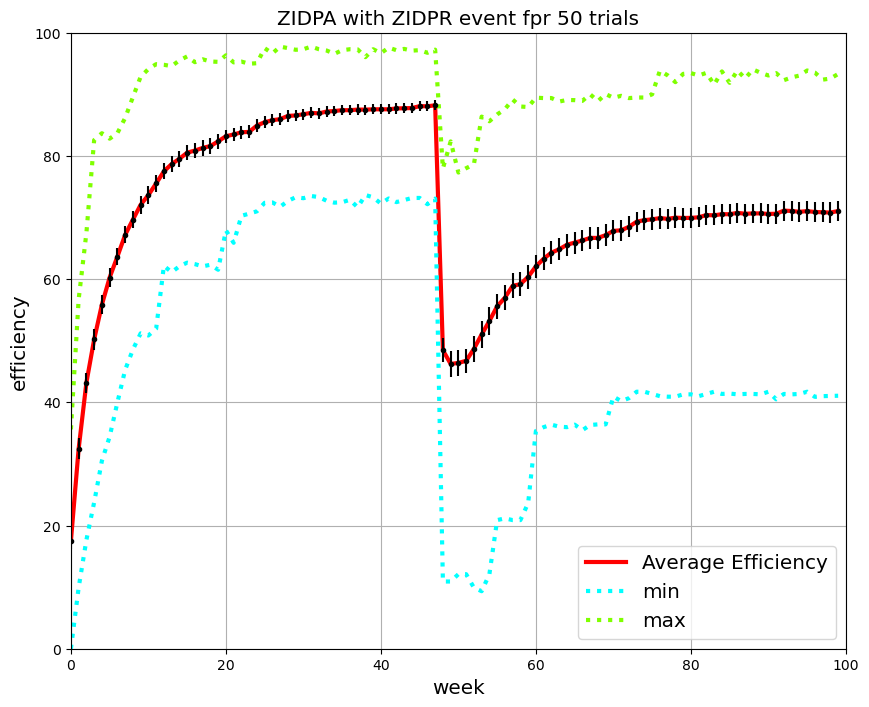

In [5]:
x = range(num_weeks)
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(x, eff_avg, label = 'Average Efficiency', linestyle = 'solid', color='red', lw =3)
ax.errorbar(x, eff_avg, yerr=std_error, fmt='.k')
ax.plot(x, eff_min, label = 'min', linestyle = 'dotted', color='cyan', lw =3)
ax.plot(x, eff_max, label = 'max', linestyle = 'dotted', color='chartreuse', lw =3)

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks)
ax.set_ybound(0, 100)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title(f'ZIDPA with ZIDPR event fpr {num_trials} trials', size = 'x-large')
ax.legend(fontsize='x-large')

plt.show()

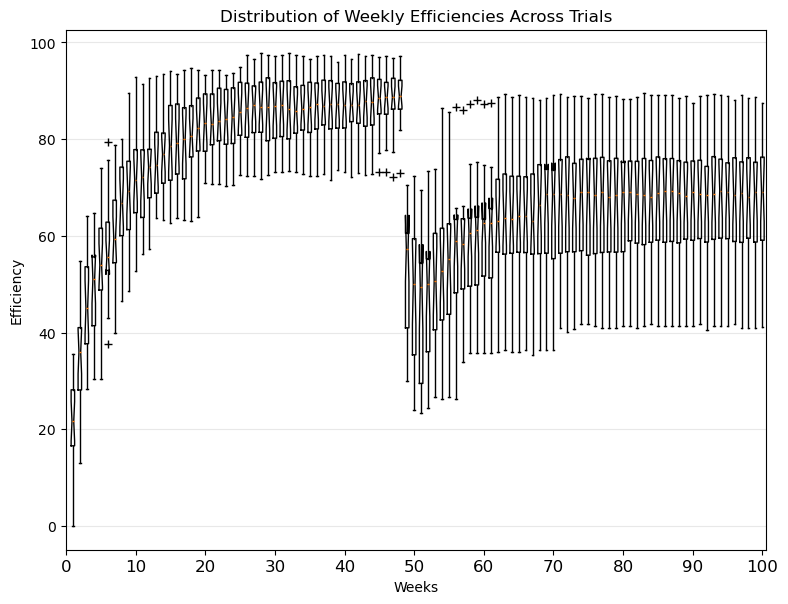

In [45]:
box_data = sim_utils.get_trial_week_effs(num_trials, num_weeks, data_table)
fig, ax1 = plt.subplots(figsize=(8, 8))
fig.canvas.manager.set_window_title('A Boxplot Example')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(box_data, notch=True, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    title="Distribution of Weekly Efficiencies Across Trials",
    xlabel="Weeks",
    ylabel='Efficiency',
)

ax1.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax1.set_xticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], fontsize=12)

plt.show()



In [48]:
def plot_boxplot_data(boxplot_data, title=None, y_lab=None, x_lab=None, x_ticks=None, x_tick_labs=None):
    fig, ax1 = plt.subplots(figsize=(8, 8))
    fig.canvas.manager.set_window_title('A Boxplot Example')
    fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
    
    bp = ax1.boxplot(boxplot_data, notch=True, sym='+', vert=1, whis=1.5)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+')
    
    # Add a horizontal grid to the plot, but make it very light in color
    # so we can use it for reading data values but not be distracting
    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)
    
    ax1.set(
        axisbelow=True,  # Hide the grid behind plot objects
        title="Distribution of Weekly Efficiencies Across Trials",
        xlabel="Weeks",
        ylabel='Efficiency',
    )

    if title is not None:
        ax1.set(title=title)

    if y_lab is not None:
        ax1.set(ylabel=y_lab)

    if x_lab is not None:
        ax1.set(xlabel=x_lab)

    if x_ticks is not None:
        ax1.set_xticks(x_ticks)

    if x_tick_labs is not None:
        ax1.set_xticklabels(x_tick_labs, fontsize=12)

    # Override standard tick labels with provided x_ticks if x_tick_labs not provided
    if x_ticks is not None and x_tick_labs is None:
        ax1.set_xticklabels(x_ticks, fontsize=12)
    
    plt.show()

In [47]:
# Name simulation - baseline: 0.00 error rate, 1.00 compliance rate
sim_name = "sim_e000_c100"

# Common controls
num_trials = 20; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

# Treatment Variables - four cases for demonstration; many levels for factor analysis
movement_error_rate = 0; compliance_rate = 1
treatment_vars = [movement_error_rate, compliance_rate]

sim_e000_c100 = make_event_monte_carlo(sim_name, *common_controls, *treatment_vars, return_df=True)

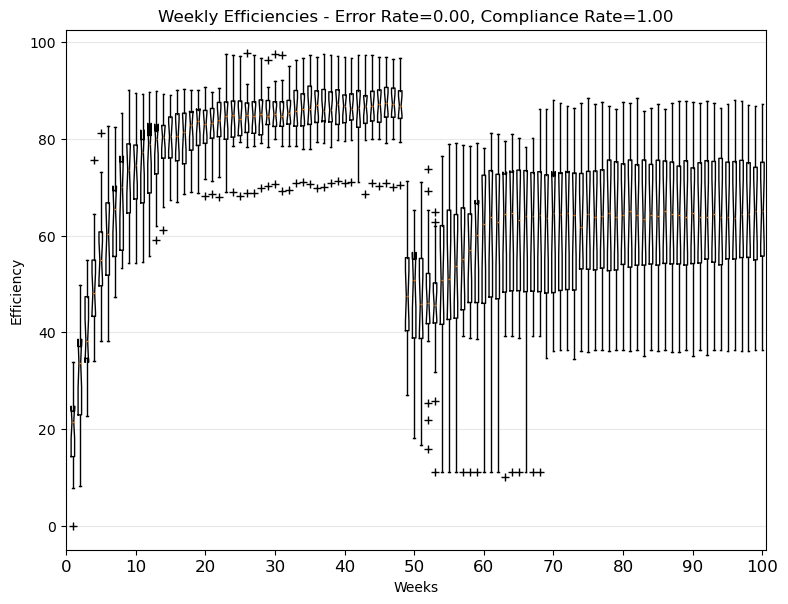

In [52]:
mtx_e000_c100 = format_df_for_boxplot(sim_e000_c100, 'week', 'eff')
title="Weekly Efficiencies - Error Rate=0.00, Compliance Rate=1.00"
xlabel="Weeks"
ylabel='Efficiency'
week_xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

plot_boxplot_data(mtx_e000_c100, title=title, y_lab=ylabel, x_lab=xlabel, x_ticks=week_xticks)

In [53]:
movement_error_rate = 0.05; compliance_rate = 1
treatment_vars = [movement_error_rate, compliance_rate]

sim_e005_c100 = make_event_monte_carlo("sim_e005_c100", *common_controls, *treatment_vars, return_df=True)

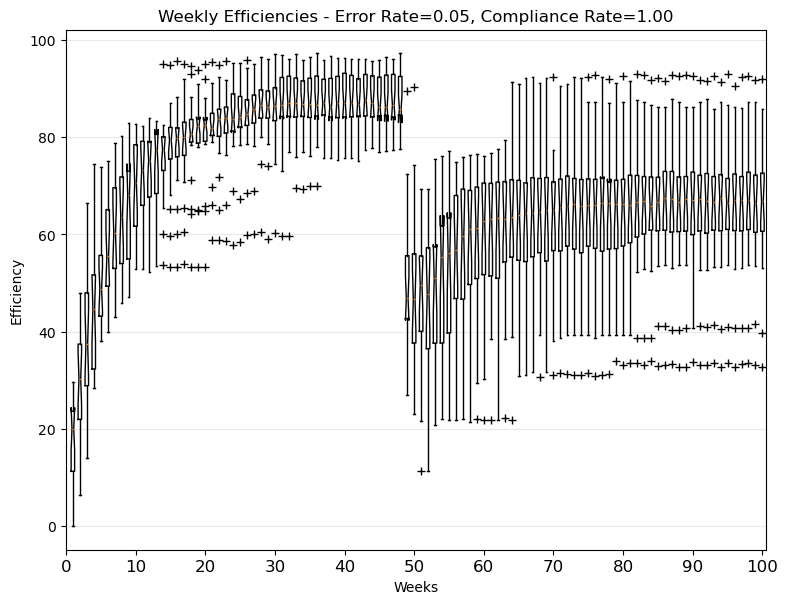

In [54]:
mtx_e005_c100 = format_df_for_boxplot(sim_e005_c100, 'week', 'eff')
title="Weekly Efficiencies - Error Rate=0.05, Compliance Rate=1.00"
plot_boxplot_data(mtx_e005_c100, title=title, y_lab=ylabel, x_lab=xlabel, x_ticks=week_xticks)

In [55]:
movement_error_rate = 0; compliance_rate = 0.75
treatment_vars = [movement_error_rate, compliance_rate]

sim_e000_c075 = make_event_monte_carlo("sim_e000_c075", *common_controls, *treatment_vars, return_df=True)

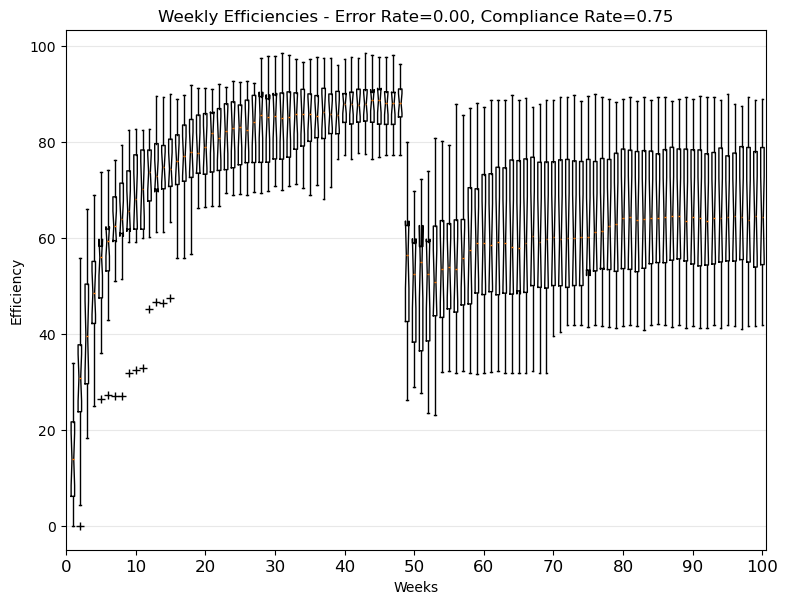

In [56]:
mtx_e000_c075 = format_df_for_boxplot(sim_e000_c075, 'week', 'eff')
title="Weekly Efficiencies - Error Rate=0.00, Compliance Rate=0.75"
plot_boxplot_data(mtx_e000_c075, title=title, y_lab=ylabel, x_lab=xlabel, x_ticks=week_xticks)

In [57]:
movement_error_rate = 0.05; compliance_rate = 0.75
treatment_vars = [movement_error_rate, compliance_rate]

sim_e005_c075 = make_event_monte_carlo("sim_e005_c075", *common_controls, *treatment_vars, return_df=True)

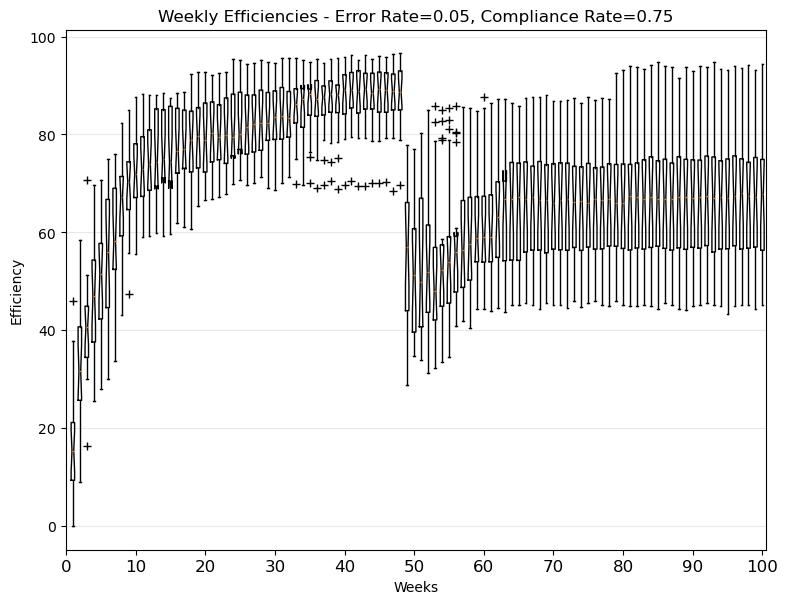

In [58]:
mtx_e005_c075 = format_df_for_boxplot(sim_e005_c075, 'week', 'eff')
title="Weekly Efficiencies - Error Rate=0.05, Compliance Rate=0.75"
plot_boxplot_data(mtx_e005_c075, title=title, y_lab=ylabel, x_lab=xlabel, x_ticks=week_xticks)